In [14]:
# Limpiamos todas las variables
#%reset -f


# Entrenamiento Yolo11
# **TACO Trash -	[taco-trash-dataset](https://www.kaggle.com/datasets/kneroma/tacotrashdataset)**
# Integrantes

|N° SIU| NOMBRE APELLIDO--------------| CORREO---------------------|
|-----|-------------------------------|----------------------------|
|a1904|	Marck Anthony Murillo Ronquillo| murillo.ronq.50c2@gmail.com|
|a1906|	Yandri Jair	Uchuari Gallardo| yandriuchuari@gmail.com|
|a1823|	Luis Alberto Santamaria Jimenez| santamaria.luigi@gmail.com|

Para la solución del problema de detección se escogió el modelo de yolo 11 el mismo es muy utilizado en tareas de detección en tiempo real de videos e imágenes si bien en nuestro proyecto no realizamos una pruebas de detección en tiempo real (video), Yolo es un modelo muy robusto en la detección de múltiples objetos en un mismo entrono, objetos con de diferentes escalas. 




Como bien ya se sabe el dataset de taco-trash presenta un gran problema en el desbalanceo de algunas clases ejemplo batería. En este experimento tratamos el desbalanceo utilizando 
-	Agrupación de las 60 categorías a 28 supercategory
-	DATA AUGMENTATION
-	OVERSAMPLING Inteligente




In [15]:
# descarga del dataset desde kagglehub
# Instalamos librerias
try:
    import os
    import kagglehub
    from tqdm import tqdm
    #import gdown
    # Para YOLOv11
    from ultralytics import YOLO
    import torch
    print("Todas las librerías ya están instaladas")
except ImportError:
    !pip install kagglehub
    !pip install tqdm
    #!pip install --upgrade --no-cache-dir gdown
    !pip install ultralytics
    !pip install torch
    print("Instalación completada")
    # Para YOLOv11
    import kagglehub
    from tqdm import tqdm
    from ultralytics import YOLO
    import torch

# Establecer la carpeta actual como caché
os.environ["KAGGLEHUB_CACHE"] = os.getcwd()

# Ruta esperada del dataset
dataset_path = os.path.join(os.getcwd(),"datasets")
#print(path)
# Verificar si ya existe
if os.path.isdir(dataset_path):
    print("El dataset ya está descargado en:", dataset_path)
    #print(path)
else:
    # Descargar solo si no existe - latest version
    path = kagglehub.dataset_download("kneroma/tacotrashdataset", force_download=True)
    print("Dataset descargado en:", dataset_path)


Todas las librerías ya están instaladas
El dataset ya está descargado en: /content/datasets


In [16]:
# YOLOv11 Training con TACO Trash Dataset
# Notebook para entrenar un modelo de detección de basura

import json
import os
import shutil
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2


# Para YOLOv11 información del chip
from ultralytics import YOLO
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla T4


In [17]:
# Optimización automática según hardware disponible para el entrenamiento.
#import platform
#import psutil

def configure_training_device():
    """
    parámetros de entrenamiento
    device= Detección de CPU / GPU
    batch= cuántas imágenes se procesan simultáneamente
    seed = semilla
    amp= GPUs modernas con soporte Tensor Cores
    workers= optimizados nun subprocesos

    """

    if torch.cuda.is_available():
        device = 'cuda'
        # Configuración optimizada para GPU
        recommended_batch = 14
        recommended_workers = 4
        mixed_precision = True

        # Información de GPU
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3

        print(f" Entrenamiento con GPU: {gpu_name}")
        print(f"   Memoria GPU: {gpu_memory:.1f} GB")
        #print(f"   Batch size recomendado: {recommended_batch}")
        #print(f"   Mixed Precision: {'Activado' if mixed_precision else 'Desactivado'}")

        # Ajustar batch size según memoria GPU
        if gpu_memory < 4:
            recommended_batch = 4
            print(f"-Warning- GPU con poca memoria, reduciendo batch a {recommended_batch}")
        elif gpu_memory < 8:
            recommended_batch = 8
            print(f" -Warning- Memoria moderada, batch recomendado: {recommended_batch}")

    ## Configuración para Apple Silicon
    #elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    #    device = 'mps'
    #    # Configuración optimizada para Apple Silicon
    #    recommended_batch = 6
    #    recommended_workers = 4
    #    mixed_precision = True
    #
    #    # Información del sistema Apple
    #    system_info = platform.uname()
    #    cpu_info = platform.processor()
    #    total_memory = psutil.virtual_memory().total / 1024**3
    #
    #    print(f"APPLE SILICON (MPS) Chip: {cpu_info}")
    #    print(f"   Sistema: {system_info.system} {system_info.release}")
    #    print(f"   Memoria Total: {total_memory:.1f} GB")
    #    print(f"   Batch size recomendado: {recommended_batch}")
    #    print(f"   Mixed Precision: {'Activado' if mixed_precision else 'Desactivado'}")
    #
    #    # Ajustar según memoria disponible
    #    available_memory = psutil.virtual_memory().available / 1024**3
    #    if available_memory < 8:
    #        recommended_batch = 6
    #        print(f" -Warning- Memoria disponible baja, reduciendo batch a {recommended_batch}")

    else:
        device = 'cpu'
        # Configuración optimizada para CPU
        recommended_batch = 2  # Mucho menor para CPU
        recommended_workers = 2
        #recommended_batch = 4  # Mucho menor para CPU
        #recommended_workers = 4
        mixed_precision = False
        # Información del CPU
        #system_info = platform.uname()
        #cpu_info = platform.processor()
        #cpu_cores = psutil.cpu_count(logical=False)  # Núcleos físicos
        #cpu_threads = psutil.cpu_count(logical=True)  # Threads lógicos
        #total_memory = psutil.virtual_memory().total / 1024**3
        #available_memory = psutil.virtual_memory().available / 1024**3

        print(f" Entrenamiento con CPU Procesador: {torch.get_num_threads()} threads disponibles")
        #print(f"   Procesador: {cpu_info}")
        #print(f"   Sistema: {system_info.system} {system_info.release}")
        #print(f"   Núcleos físicos: {cpu_cores}")
        #print(f"   Threads totales: {cpu_threads}")
        #print(f"   Memoria Total: {total_memory:.1f} GB")
        #print(f"   Memoria Disponible: {available_memory:.1f} GB")



    return {
        'device': device,
        'batch_size': recommended_batch,
        'workers': recommended_workers,
        'mixed_precision': mixed_precision
    }

# Configurar automáticamente
training_config = configure_training_device()

seed = 42

# Aplicar configuración automática
AUTO_BATCH_SIZE = training_config['batch_size']
AUTO_WORKERS = training_config['workers']
AUTO_DEVICE = training_config['device']
AUTO_AMP = training_config['mixed_precision']

print(f"\n******* Configuración Básica para entrenamiento *************")
print(f"   Device: {AUTO_DEVICE}")
print(f"   Batch Size: {AUTO_BATCH_SIZE}")
print(f"   Workers: {AUTO_WORKERS}")
print(f"   AMP (Mixed Precision): {AUTO_AMP}")
print(f"   Seed: {seed}")





 Entrenamiento con GPU: Tesla T4
   Memoria GPU: 14.7 GB

******* Configuración Básica para entrenamiento *************
   Device: cuda
   Batch Size: 14
   Workers: 4
   AMP (Mixed Precision): True
   Seed: 42


In [ ]:
## 1. CONFIGURACIÓN INICIAL Y PATHS

# Configurar paths del dataset
dataset_path = './datasets/kneroma/tacotrashdataset/versions/3/data' # win
#dataset_path = './kaggle/input/tacotrashdataset/data/' # Colab 
annotations_file = os.path.join(dataset_path, 'annotations.json')
images_dir = dataset_path

# Crear directorios para YOLO
yolo_dataset_path = './yolo_taco_dataset'
os.makedirs(yolo_dataset_path, exist_ok=True)
os.makedirs(f'{yolo_dataset_path}/images/train', exist_ok=True)
os.makedirs(f'{yolo_dataset_path}/images/val', exist_ok=True)
os.makedirs(f'{yolo_dataset_path}/labels/train', exist_ok=True)
os.makedirs(f'{yolo_dataset_path}/labels/val', exist_ok=True)

In [19]:

## 2. CARGAR Y EXPLORAR EL DATASET

# Cargar annotations JSON
try:
    with open(annotations_file, 'r') as f:
        coco_data = json.load(f)
    print("Archivo JSON cargado .... exitosamente")
except FileNotFoundError:
    print("Error: No se encontró el archivo annotations.json")
    exit()

# Información del dataset
print(f"INFORMACIÓN DEL DATASET:")
print(f"  Total de imágenes: {len(coco_data['images'])}")
print(f"  Total de anotaciones: {len(coco_data['annotations'])}")
print(f"  Total de categorías: {len(coco_data['categories'])}")

# extrae supercategorías únicas de todas las categorías
supercategories = set(cat['supercategory'] for cat in coco_data['categories'])
print(f"  Total de supercategorías: {len(supercategories)}")


# Calculo de relación imagen con categoría.
image_ids = set(img['id'] for img in coco_data['images'])
annotation_image_ids = set(ann['image_id'] for ann in coco_data['annotations'])
images_with_annotations = image_ids.intersection(annotation_image_ids)
print(f"  Total de imágenes relacionadas con anotaciones: {len(images_with_annotations)}")
print(f"  Total de imágenes sin anotaciones: {len(image_ids) - len(images_with_annotations)}")





Archivo JSON cargado .... exitosamente
INFORMACIÓN DEL DATASET:
  Total de imágenes: 1500
  Total de anotaciones: 4784
  Total de categorías: 60
  Total de supercategorías: 28
  Total de imágenes relacionadas con anotaciones: 1500
  Total de imágenes sin anotaciones: 0


In [ ]:
### ANÁLISIS EXPLORATORIO DE DATOS -- INFO GENERAL EDA
#
#def analyze_dataset(coco_data):
#    """Análisis exploratorio del dataset"""
#
#    # Crear DataFrame para análisis
#    categories_df = pd.DataFrame(coco_data['categories'])
#    annotations_df = pd.DataFrame(coco_data['annotations'])
#    images_df = pd.DataFrame(coco_data['images'])
#
#    # Estadísticas por categoría
#    cat_counts = annotations_df['category_id'].value_counts().sort_index()
#
#    # Convertir a DataFrame y corregir nombres de columnas
#    cat_counts_df = cat_counts.reset_index()
#    cat_counts_df.columns = ['category_id', 'count']  # Renombrar columnas explícitamente
#
#    # Merge para obtener nombres
#    cat_stats = pd.merge(
#        cat_counts_df,
#        categories_df[['id', 'name', 'supercategory']],
#        left_on='category_id',
#        right_on='id'
#    )[['name', 'supercategory', 'count']].sort_values('count', ascending=False)
#
#    print(f"\n TOP 10 CATEGORÍAS MÁS FRECUENTES:")
#    print(cat_stats.head(10).to_string(index=False))
#
#    # Estadísticas de bounding boxes
#    print(f"\n ESTADÍSTICAS DE BOUNDING BOXES:")
#    bbox_areas = [ann['area'] for ann in coco_data['annotations']]
#    print(f"Área promedio: {np.mean(bbox_areas):.2f}")
#    print(f"Área mediana: {np.median(bbox_areas):.2f}")
#    print(f"Área mínima: {np.min(bbox_areas):.2f}")
#    print(f"Área máxima: {np.max(bbox_areas):.2f}")
#
#    # Estadísticas de imágenes
#    widths = [img['width'] for img in coco_data['images']]
#    heights = [img['height'] for img in coco_data['images']]
#
#    print(f"\n ESTADÍSTICAS DE IMÁGENES:")
#    print(f"Ancho promedio: {np.mean(widths):.0f}px")
#    print(f"Alto promedio: {np.mean(heights):.0f}px")
#
#    # Calcular resolución más común (corregido)
#    resolutions = list(zip(widths, heights))
#    most_common_resolution = max(set(resolutions), key=resolutions.count)
#    print(f"Resolución más común: {most_common_resolution[0]}x{most_common_resolution[1]}")
#
#    # Estadísticas adicionales de resoluciones
#    unique_resolutions = set(resolutions)
#    print(f"Total de resoluciones únicas: {len(unique_resolutions)}")
#
#    return cat_stats, bbox_areas
#
## Ejecutar análisis
#cat_stats, bbox_areas = analyze_dataset(coco_data)

In [ ]:
### VISUALIZACIÓN DE DATOS -- INFO GENERAL EDA
#
#def plot_dataset_statistics(cat_stats, bbox_areas):
#    """Crear gráficos del dataset"""
#
#    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
#
#    # 1. Top categorías
#    top_cats = cat_stats.head(15)
#    axes[0,0].barh(top_cats['name'], top_cats['count'])
#    axes[0,0].set_title('Top 15 Categorías por Frecuencia')
#    axes[0,0].set_xlabel('Número de Anotaciones')
#
#    # 2. Distribución por supercategoría
#    super_cats = cat_stats.groupby('supercategory')['count'].sum().sort_values(ascending=False)
#    axes[0,1].pie(super_cats.values, labels=super_cats.index, autopct='%1.1f%%')
#    axes[0,1].set_title('Distribución por Supercategoría')
#
#    # 3. Distribución de áreas de bboxes
#    axes[1,0].hist(bbox_areas, bins=50, alpha=0.7)
#    axes[1,0].set_title('Distribución de Áreas de Bounding Boxes')
#    axes[1,0].set_xlabel('Área')
#    axes[1,0].set_ylabel('Frecuencia')
#    axes[1,0].set_yscale('log')
#
#    # 4. Log de áreas para mejor visualización
#    log_areas = np.log10([area for area in bbox_areas if area > 0])
#    axes[1,1].hist(log_areas, bins=30, alpha=0.7)
#    axes[1,1].set_title('Log10 de Áreas de Bounding Boxes')
#    axes[1,1].set_xlabel('Log10(Área)')
#    axes[1,1].set_ylabel('Frecuencia')
#
#    plt.tight_layout()
#    plt.show()
#
## Generar gráficos
#plot_dataset_statistics(cat_stats, bbox_areas)

In [22]:
### 3. CONVERSIÓN DE COCO A YOLO --- TOMAR 60 CATEGORIAS QUE ESTAN EN EL JSON
#
#def coco_to_yolo_bbox(coco_bbox, img_width, img_height):
#    """Convertir bbox de COCO a formato YOLO"""
#    x, y, w, h = coco_bbox
#
#    # Convertir a centro y normalizar
#    x_center = (x + w/2) / img_width
#    y_center = (y + h/2) / img_height
#    width = w / img_width
#    height = h / img_height
#
#    return [x_center, y_center, width, height]
#
#def convert_coco_to_yolo(coco_data, output_dir):
#    """Convertir dataset COCO a formato YOLO"""
#
#    # Crear mapeo de image_id a info
#    images_dict = {img['id']: img for img in coco_data['images']}
#
#    # Crear mapeo de category_id a índice YOLO (0-indexed)
#    categories = sorted(coco_data['categories'], key=lambda x: x['id'])
#    category_mapping = {cat['id']: idx for idx, cat in enumerate(categories)}
#
#    print(f"\nCONVERSIÓN A FORMATO YOLO:")
#    print(f"Mapeo de categorías: {len(category_mapping)} categorías")
#
#    # Agrupar anotaciones por imagen
#    annotations_by_image = {}
#    for ann in coco_data['annotations']:
#        img_id = ann['image_id']
#        if img_id not in annotations_by_image:
#            annotations_by_image[img_id] = []
#        annotations_by_image[img_id].append(ann)
#
#    successful_conversions = 0
#
#    #for img_id, annotations in annotations_by_image.items():
#    for img_id, annotations in tqdm(annotations_by_image.items(), desc="Convirtiendo a YOLO"):
#        if img_id not in images_dict:
#            continue
#
#        img_info = images_dict[img_id]
#        img_width = img_info['width']
#        img_height = img_info['height']
#
#        # Crear archivo de labels YOLO
#        yolo_labels = []
#        for ann in annotations:
#            if ann['category_id'] in category_mapping:
#                class_id = category_mapping[ann['category_id']]
#                bbox = coco_to_yolo_bbox(ann['bbox'], img_width, img_height)
#
#                # Validar bbox
#                if all(0 <= coord <= 1 for coord in bbox):
#                    yolo_labels.append(f"{class_id} {' '.join(map(str, bbox))}")
#
#        if yolo_labels:
#            # Nombre del archivo (sin extensión)
#            img_filename = os.path.splitext(img_info['file_name'])[0]
#
#            # Guardar labels
#            label_path = os.path.join(output_dir, f"{img_filename}.txt")
#            os.makedirs(os.path.dirname(label_path), exist_ok=True)
#
#            with open(label_path, 'w') as f:
#                f.write('\n'.join(yolo_labels))
#
#            successful_conversions += 1
#
#    print(f"Convertidas {successful_conversions} imágenes con sus labels")
#
#    return category_mapping, categories
#
## Ejecutar conversión
#category_mapping, categories = convert_coco_to_yolo(coco_data, yolo_dataset_path)

#### Agrupación a supercategory y conver de coco a formato yolo

A partir de este unto comenzamos el proceso de reducir  las 60 categorías a 28 supercategory que tenemos ya previamente definidos en el archivo json en la clave principal categories. La finalidad de esta agrupación es mejorar el desbalance que se tiene en el dataset , específicamente en aquellas donde tenemos pocas imágenes que las identifique 

```markdown
images[id=9] ←→ annotations[image_id=9] ←→ categories[id=50] y supercategory
                      ↓
               scene_annotations[image_id=9] ←→ scene_categories[id=1]
```




In [23]:
##v2 3. CONVERSIÓN DE COCO A YOLO FORMAT - MODIFICADO PARA TOMAR POR LAS 28 SUPERCATEGORÍAS QUE ESTAN EN EL .JSON

def coco_to_yolo_bbox(coco_bbox, img_width, img_height):
    """Convertir bbox de COCO a formato YOLO"""
    x, y, w, h = coco_bbox

    # Convertir a centro y normalizar
    x_center = (x + w/2) / img_width
    y_center = (y + h/2) / img_height
    width = w / img_width
    height = h / img_height

    return [x_center, y_center, width, height]

def convert_coco_to_yolo_supercategories(coco_data, output_dir):
    """Convertir dataset COCO a formato YOLO usando SUPERCATEGORÍAS"""

    # Crear mapeo de image_id a info
    images_dict = {img['id']: img for img in coco_data['images']}

    # PASO 1: Extraer supercategorías únicas
    supercategories_set = set()
    for cat in coco_data['categories']:
        if cat['supercategory']:  # Verificar que no sea None o vacío
            supercategories_set.add(cat['supercategory'])

    # Convertir a lista ordenada para consistencia
    unique_supercategories = sorted(list(supercategories_set))
    #INFO GENERAL
    #print(f"Total de supercategorías encontradas: {len(unique_supercategories)}")
    #print(f"Supercategorías: {unique_supercategories[:5]}... (mostrando primeras 5)")

    # PASO 2: Crear mapeo de supercategory_name -> índice YOLO (0-indexed)
    supercategory_to_yolo_mapping = {supercategory: idx for idx, supercategory in enumerate(unique_supercategories)}

    # PASO 3: Crear mapeo de category_id -> supercategory para las anotaciones
    category_id_to_supercategory = {}
    for cat in coco_data['categories']:
        category_id_to_supercategory[cat['id']] = cat['supercategory']

    #Mapeo creado
    #print(f"- {len(supercategory_to_yolo_mapping)} supercategorías mapeadas a índices YOLO ")
    print(f"- {len(category_id_to_supercategory)} categorías originales mapeadas a {len(supercategory_to_yolo_mapping)} supercategorías")

    # PASO 4: Agrupar anotaciones por imagen
    annotations_by_image = {}
    for ann in coco_data['annotations']:
        img_id = ann['image_id']
        if img_id not in annotations_by_image:
            annotations_by_image[img_id] = []
        annotations_by_image[img_id].append(ann)

    successful_conversions = 0
    supercategory_counts = {supercat: 0 for supercat in unique_supercategories}

    # PASO 5: Procesar cada imagen y sus anotaciones
    for img_id, annotations in tqdm(annotations_by_image.items(), desc="Convirtiendo a YOLO (Supercategorías)"):
        if img_id not in images_dict:
            continue

        img_info = images_dict[img_id]
        img_width = img_info['width']
        img_height = img_info['height']

        # Crear archivo de labels YOLO
        yolo_labels = []
        for ann in annotations:
            original_category_id = ann['category_id']

            # Obtener supercategoría de la categoría original
            if original_category_id in category_id_to_supercategory:
                supercategory_name = category_id_to_supercategory[original_category_id]

                # Obtener índice YOLO de la supercategoría
                if supercategory_name in supercategory_to_yolo_mapping:
                    yolo_class_id = supercategory_to_yolo_mapping[supercategory_name]
                    bbox = coco_to_yolo_bbox(ann['bbox'], img_width, img_height)

                    # Validar bbox
                    if all(0 <= coord <= 1 for coord in bbox):
                        yolo_labels.append(f"{yolo_class_id} {' '.join(map(str, bbox))}")
                        supercategory_counts[supercategory_name] += 1

        if yolo_labels:
            # Nombre del archivo (sin extensión)
            img_filename = os.path.splitext(img_info['file_name'])[0]

            # Guardar labels
            label_path = os.path.join(output_dir, f"{img_filename}.txt")
            os.makedirs(os.path.dirname(label_path), exist_ok=True)

            with open(label_path, 'w') as f:
                f.write('\n'.join(yolo_labels))

            successful_conversions += 1

    print(f"\nConversión completada:")
    print(f"- Convertidas {successful_conversions} imágenes con sus labels")
    print(f"- Total de detecciones procesadas: {sum(supercategory_counts.values())}")

    #return supercategory_to_yolo_mapping, unique_supercategories, supercategory_counts
    #  5 variables para oversampling
    return (supercategory_to_yolo_mapping, unique_supercategories, supercategory_counts,
            annotations_by_image, category_id_to_supercategory)

# EJECUTAR LA CONVERSIÓN MODIFICADA
print("Iniciando conversión COCO -> YOLO clasificando por supercategory...")

# supercategory_mapping, unique_supercategories, detection_counts = convert_coco_to_yolo_supercategories(coco_data, yolo_dataset_path
# llamada a la fucnión - Capturar las 5 variables
supercategory_mapping, unique_supercategories, detection_counts, annotations_by_image, category_id_to_supercategory = convert_coco_to_yolo_supercategories(coco_data, yolo_dataset_path)

#print(f"\TESTING VARIABLES DISPONIBLES PARA OVERSAMPLING EN EL  BLOQUE 5 :")
#print(f"- supercategory_mapping: {len(supercategory_mapping)} clases")
#print(f"- unique_supercategories: {len(unique_supercategories)} supercategorías")
#print(f"- detection_counts: {len(detection_counts)} conteos")
#print(f"- annotations_by_image: {len(annotations_by_image)} imágenes")
#print(f"- category_id_to_supercategory: {len(category_id_to_supercategory)} mapeos")

print(f"\n Mapeo de supercategorías creado: {len(supercategory_mapping)} clases")
print(f"Archivos convertidos exitosamente!")


Iniciando conversión COCO -> YOLO clasificando por supercategory...
- 60 categorías originales mapeadas a 28 supercategorías


Convirtiendo a YOLO (Supercategorías): 100%|██████████| 1500/1500 [00:00<00:00, 11507.98it/s]


Conversión completada:
- Convertidas 1500 imágenes con sus labels
- Total de detecciones procesadas: 4784

 Mapeo de supercategorías creado: 28 clases
Archivos convertidos exitosamente!


In [ ]:
## 4. DIVIDIR DATASET EN TRAIN/VAL


def split_dataset(coco_data, train_ratio, random_state):
    """Dividir dataset en train y validation"""

    images = coco_data['images']

    # Obtener solo imágenes que tienen anotaciones
    images_with_annotations = []
    annotations_by_image = {}

    for ann in coco_data['annotations']:
        img_id = ann['image_id']
        if img_id not in annotations_by_image:
            annotations_by_image[img_id] = []
        annotations_by_image[img_id].append(ann)

    for img in images:
        if img['id'] in annotations_by_image:
            images_with_annotations.append(img)

    print(f"\nDivisión del data set:")
    print(f"Imágenes con anotaciones: {len(images_with_annotations)}")

    # División train/val
    train_imgs, val_imgs = train_test_split(
        images_with_annotations,
        train_size=train_ratio,
        random_state=random_state
    )

    print(f"Entrenamiento: {len(train_imgs)} imágenes")
    print(f"Validación: {len(val_imgs)} imágenes")

    return train_imgs, val_imgs

# Dividir dataset
#train_images, val_images = split_dataset(coco_data,train_ratio=0.8, random_state=seed)
train_images, val_images = split_dataset(coco_data,train_ratio=0.9, random_state=seed)




División del data set:
Imágenes con anotaciones: 1500
Entrenamiento: 1350 imágenes
Validación: 150 imágenes


In [25]:
### 5. COPIAR ARCHIVOS A ESTRUCTURA YOLO SIN APLICAR OVERSAMPLING INTELIGENTE
#
#def copy_files_to_yolo_structure(images_list, split_name, source_dir, target_dir):
#    """Copiar imágenes y labels a estructura YOLO"""
#
#    copied_images = 0
#    copied_labels = 0
#
#    #for img_info in images_list:
#    for img_info in tqdm(images_list, desc=f"Copiando {split_name}"):
#        # Copiar imagen
#        src_img_path = os.path.join(source_dir, img_info['file_name'])
#        dst_img_path = os.path.join(target_dir, 'images', split_name, os.path.basename(img_info['file_name']))
#
#        if os.path.exists(src_img_path):
#            shutil.copy2(src_img_path, dst_img_path)
#            copied_images += 1
#
#        # Copiar label
#        img_filename = os.path.splitext(img_info['file_name'])[0]
#        src_label_path = os.path.join(yolo_dataset_path, f"{img_filename}.txt")
#        dst_label_path = os.path.join(target_dir, 'labels', split_name, f"{os.path.basename(img_filename)}.txt")
#
#        if os.path.exists(src_label_path):
#            shutil.copy2(src_label_path, dst_label_path)
#            copied_labels += 1
#
#    print(f"{split_name}: {copied_images} imágenes, {copied_labels} labels copiados")
#    return copied_images, copied_labels
#
#print(f"\n📂 COPIANDO ARCHIVOS A ESTRUCTURA YOLO:")
#
## Copiar archivos train
#train_img_count, train_label_count = copy_files_to_yolo_structure(
#    train_images, 'train', images_dir, yolo_dataset_path
#)
#
## Copiar archivos val
#val_img_count, val_label_count = copy_files_to_yolo_structure(
#    val_images, 'val', images_dir, yolo_dataset_path
#)


### Oversampling Inteligente

Son un conjunto de técnicas avanzadas de aumento de datos (data augmentation) que se utilizan para abordar el desbalance de clases de una manera más sofisticada que el simple muestreo aleatorio.

Entre los pasos que estamos realizando tenemos:  
1. Identifica Clases Minoritarias:
2. Calcula un Factor de Duplicación
3. Duplica la Imagen y sus Anotaciones:

Como podemos observar en el siguiente bloque de código 
- Battery, Shoe: duplicar 2x 
- Paper bag, Rope: duplicar 2x 


ESTADÍSTICAS DE OVERSAMPLING (TRAIN):
- Battery                  :  2 imágenes →  10 copias totales (det.orig:   2)
- Plastic glooves          :  3 imágenes →  15 copias totales (det.orig:   4)
- Glass jar                :  3 imágenes →  15 copias totales (det.orig:   6)
- Shoe                     :  5 imágenes →  25 copias totales (det.orig:   7)
- Squeezable tube          :  5 imágenes →  25 copias totales (det.orig:   7)
- Blister pack             :  7 imágenes →  35 copias totales (det.orig:   7)
- Food waste               :  6 imágenes →  30 copias totales (det.orig:   8)
- Scrap metal              : 10 imágenes →  30 copias totales (det.orig:  20)
- Paper bag                : 18 imágenes →  56 copias totales (det.orig:  27)
- Rope & strings           : 27 imágenes →  81 copias totales (det.orig:  29)
- Plastic utensils         : 27 imágenes →  81 copias totales (det.orig:  37)
- Aluminium foil           : 41 imágenes →  85 copias totales (det.orig:  62)
- Plastic container        : 61 imágenes → 128 copias totales (det.orig:  72)
- Lid                      : 64 imágenes → 141 copias totales (det.orig:  87)
- Pop tab                  : 61 imágenes → 130 copias totales (det.orig:  99)


In [ ]:
# v2 ## 5. COPIAR ARCHIVOS A ESTRUCTURA YOLO - CON OVERSAMPLING INTELIGENTE

# CREAR VARIABLES NECESARIAS PARA OVERSAMPLING (del Bloque 3)
print(" Preparando datos para oversampling...")

# Recrear mapeo de category_id -> supercategory
category_id_to_supercategory = {}
for cat in coco_data['categories']:
    category_id_to_supercategory[cat['id']] = cat['supercategory']

# Recrear agrupación de anotaciones por imagen
annotations_by_image = {}
for ann in coco_data['annotations']:
    img_id = ann['image_id']
    if img_id not in annotations_by_image:
        annotations_by_image[img_id] = []
    annotations_by_image[img_id].append(ann)

print(f"Variables preparadas:")
print(f"  - {len(category_id_to_supercategory)} categorías mapeadas a supercategorías")
print(f"  - {len(annotations_by_image)} imágenes con anotaciones agrupadas")

def get_image_supercategories(img_id, annotations_by_image, category_id_to_supercategory):
    """Obtener supercategorías presentes en una imagen específica"""
    if img_id not in annotations_by_image:
        return set()

    img_supercategories = set()
    for ann in annotations_by_image[img_id]:
        category_id = ann['category_id']
        if category_id in category_id_to_supercategory:
            supercat = category_id_to_supercategory[category_id]
            img_supercategories.add(supercat)

    return img_supercategories

def calculate_oversampling_factor(img_supercategories, detection_counts, is_validation=False):
    """Calcular factor de duplicación basado en supercategorías minoritarias"""

    # Encontrar la clase más rara en la imagen
    min_detection_count = float('inf')
    for supercat in img_supercategories:
        if supercat in detection_counts:
            count = detection_counts[supercat]
            min_detection_count = min(min_detection_count, count)

    # Si no se encontraron supercategorías válidas
    if min_detection_count == float('inf'):
        return 1

    # Factores de duplicación según criterio
    if is_validation:
        # VALIDATION SET - Factor reducido para evaluación más realista
        if min_detection_count < 10:
            return 2    # Battery, Shoe: duplicar 2x en val
        elif min_detection_count < 50:
            return 2    # Paper bag, Rope: duplicar 2x en val
        elif min_detection_count < 100:
            return 1    # Pop tab, Lid: no duplicar en val
        else:
            return 1    # Clases frecuentes: no duplicar
    else:
        # TRAIN SET - Factor completo para aprendizaje máximo
        if min_detection_count < 10:
            return 5    # Battery, Shoe: duplicar 5x en train
        elif min_detection_count < 50:
            return 3    # Paper bag, Rope: duplicar 3x en train
        elif min_detection_count < 100:
            return 2    # Pop tab, Lid: duplicar 2x en train
        else:
            return 1    # Clases frecuentes: no duplicar

def copy_files_to_yolo_structure_with_oversampling(images_list, split_name, source_dir, target_dir):
    """Copiar imágenes y labels a estructura YOLO CON OVERSAMPLING INTELIGENTE"""

    copied_images = 0
    copied_labels = 0
    total_duplications = 0
    oversampling_stats = {}

    is_validation = (split_name == 'val')

    print(f"\nCOPIANDO {split_name.upper()} CON OVERSAMPLING INTELIGENTE:")
    print(f"Umbral para oversampling: < 100 detecciones")
    print(f"Modo: {'VALIDATION (factor reducido)' if is_validation else 'TRAIN (factor completo)'}")

    for img_info in tqdm(images_list, desc=f"Procesando {split_name}"):
        img_id = img_info['id']
        base_filename = os.path.splitext(img_info['file_name'])[0]

        # Obtener supercategorías de esta imagen
        img_supercategories = get_image_supercategories(
            img_id, annotations_by_image, category_id_to_supercategory
        )

        # Calcular factor de oversampling
        oversample_factor = calculate_oversampling_factor(
            img_supercategories, detection_counts, is_validation
        )

        # Estadísticas de oversampling
        if oversample_factor > 1:
            minority_classes = [sc for sc in img_supercategories
                              if detection_counts.get(sc, float('inf')) < 100]
            for mc in minority_classes:
                if mc not in oversampling_stats:
                    oversampling_stats[mc] = {'images': 0, 'total_copies': 0}
                oversampling_stats[mc]['images'] += 1
                oversampling_stats[mc]['total_copies'] += oversample_factor

        # Copiar imagen original + duplicados
        for copy_idx in range(oversample_factor):
            # Nombres únicos para cada copia
            if copy_idx == 0:
                # Primera copia (original)
                img_suffix = ""
                label_suffix = ""
            else:
                # Copias adicionales (oversampling)
                img_suffix = f"_os{copy_idx}"
                label_suffix = f"_os{copy_idx}"
                total_duplications += 1

            # Rutas de origen
            src_img_path = os.path.join(source_dir, img_info['file_name'])
            src_label_path = os.path.join(yolo_dataset_path, f"{base_filename}.txt")

            # Rutas de destino
            dst_img_name = f"{base_filename}{img_suffix}{os.path.splitext(img_info['file_name'])[1]}"
            dst_label_name = f"{base_filename}{label_suffix}.txt"

            dst_img_path = os.path.join(target_dir, 'images', split_name, dst_img_name)
            dst_label_path = os.path.join(target_dir, 'labels', split_name, dst_label_name)

            # Crear directorios de destino si no existen
            os.makedirs(os.path.dirname(dst_img_path), exist_ok=True)
            os.makedirs(os.path.dirname(dst_label_path), exist_ok=True)

            # Copiar imagen
            if os.path.exists(src_img_path):
                shutil.copy2(src_img_path, dst_img_path)
                copied_images += 1

            # Copiar label
            if os.path.exists(src_label_path):
                shutil.copy2(src_label_path, dst_label_path)
                copied_labels += 1

    print(f"\ {split_name.upper()} COMPLETADO:")
    print(f"  Imágenes originales: {len(images_list)}")
    print(f"  Imágenes totales copiadas: {copied_images}")
    print(f"  Labels copiados: {copied_labels}")
    print(f"  Duplicaciones por oversampling: {total_duplications}")

    if oversampling_stats:
        print(f"\nESTADÍSTICAS DE OVERSAMPLING ({split_name.upper()}):")
        for supercat, stats in sorted(oversampling_stats.items(),
                                     key=lambda x: detection_counts.get(x[0], 0)):
            original_count = detection_counts.get(supercat, 0)
            print(f"  {supercat:<25}: {stats['images']:>2d} imágenes → {stats['total_copies']:>3d} copias totales "
                  f"(det.orig: {original_count:>3d})")

    return copied_images, copied_labels, total_duplications

# EJECUTAR COPIA CON OVERSAMPLING INTELIGENTE
print(f"\nINICIANDO COPIA CON OVERSAMPLING INTELIGENTE:")
print(f"Criterio: Supercategorías con < 100 detecciones")

# Copiar archivos train CON OVERSAMPLING
train_img_count, train_label_count, train_duplications = copy_files_to_yolo_structure_with_oversampling(
    train_images, 'train', images_dir, yolo_dataset_path
)

# Copiar archivos val CON OVERSAMPLING (factor reducido)
val_img_count, val_label_count, val_duplications = copy_files_to_yolo_structure_with_oversampling(
    val_images, 'val', images_dir, yolo_dataset_path
)

print(f"\nRESUMEN GENERAL DE OVERSAMPLING:")
print(f"  Train: {len(train_images)} → {train_img_count} imágenes (+{train_duplications} duplicaciones)")
print(f"  Val: {len(val_images)} → {val_img_count} imágenes (+{val_duplications} duplicaciones)")
print(f"  Total nuevo dataset: {train_img_count + val_img_count} imágenes")
print(f"  Incremento por oversampling: {((train_duplications + val_duplications) / (len(train_images) + len(val_images))) * 100:.1f}%")

In [27]:
### 6. CREAR ARCHIVO DE CONFIGURACIÓN YAML --- TOMAR 60 CATEGORIAS QUE ESTAN EN EL JSON
#
#def create_yaml_config(categories, dataset_path):
#    """Crear archivo de configuración YAML para YOLO usando CATEGORÍAS """
#
#    config = {
#        'path': os.path.abspath(dataset_path),
#        'train': 'images/train',
#        'val': 'images/val',
#        'nc': len(categories),
#        'names': [cat['name'] for cat in categories]
#    }
#
#    yaml_path = os.path.join(dataset_path, 'data.yaml')
#
#    with open(yaml_path, 'w') as f:
#        yaml.dump(config, f, default_flow_style=False)
#
#    print(f"\nArchivo de configuración creado: {yaml_path}")
#    print(f"Número de clases: {config['nc']}")
#    print(f"Primeras 5 clases: {config['names'][:5]}")
#
#    return yaml_path
#
## Crear configuración YAML
#yaml_config_path = create_yaml_config(categories, yolo_dataset_path)

In [28]:
## 6. CREAR ARCHIVO DE CONFIGURACIÓN YAML - MODIFICADO PARA LAS 28 SUPERCATEGORÍAS

def create_yaml_config_supercategories(unique_supercategories, dataset_path):
    """Crear archivo de configuración YAML para YOLO usando SUPERCATEGORÍAS"""

    config = {
        'path': os.path.abspath(dataset_path),
        'train': 'images/train',
        'val': 'images/val',
        'nc': len(unique_supercategories),  # Ahora será 28 en lugar de 60
        'names': unique_supercategories     # Lista de 28 supercategorías
    }

    yaml_path = os.path.join(dataset_path, 'data_supercategories.yaml')

    with open(yaml_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)

    #print(f"Ubicación de configuración yaml {yaml_path}")
    #print(f"Número de clases: {config['nc']}")
    #print(f"Primeras 8 supercategorías: {config['names'][:8]}")
    #print(f"Últimas 5 supercategorías: {config['names'][-5:]}")

    # Validación adicional
    print(f"- Total de supercategorías en YAML: {len(config['names'])}")
    print(f"- VALIDACIÓN ¿Coincide con mapeo del bloque anterior? {len(config['names']) == len(supercategory_mapping)}")

    # Mostrar estructura del archivo YAML generado
    print(f"\nESTRUCTURA DEL ARCHIVO YAML:")
    print(f"  path: {config['path']}")
    print(f"  Ubicación de configuración yaml {yaml_path}")
    print(f"  train: {config['train']}")
    print(f"  val: {config['val']}")
    print(f"  nc: {config['nc']} (clases)")
    print(f"  names: [lista de {len(config['names'])} supercategorías]")

    return yaml_path, config

# EJECUTAR LA CREACIÓN DEL YAML MODIFICADO
print("CREANDO ARCHIVO DE CONFIGURACIÓN YAML CON SUPERCATEGORÍAS...")

# yaml_config_path Y yaml_config_path_supercategories son = es para diferenciar en el resultado d etesting
yaml_config_path, yaml_config = create_yaml_config_supercategories(
    unique_supercategories,
    yolo_dataset_path
)

#yaml_config_path_supercategories = yaml_config_path
## Mostrar contenido del archivo para verificar
#print(f"\n TESTING INFO RESULTADO:")
#print(f"Archivo YAML creado: {yaml_config_path_supercategories}")
#print(f"Configuración lista para entrenamiento con {yaml_config['nc']} clases")
#
#print(f"\n VERIFICACIÓN - Contenido del archivo YAML:")
#try:
#    with open(yaml_config_path_supercategories, 'r') as f:
#        yaml_content = f.read()
#    print(yaml_content)
#except Exception as e:
#    print(f"Error al leer el archivo: {e}")

CREANDO ARCHIVO DE CONFIGURACIÓN YAML CON SUPERCATEGORÍAS...
- Total de supercategorías en YAML: 28
- VALIDACIÓN ¿Coincide con mapeo del bloque anterior? True

ESTRUCTURA DEL ARCHIVO YAML:
  path: /content/yolo_taco_dataset
  Ubicación de configuración yaml ./yolo_taco_dataset/data_supercategories.yaml
  train: images/train
  val: images/val
  nc: 28 (clases)
  names: [lista de 28 supercategorías]


Entre las técnicas de **aumento de datos** para  crean nuevas variaciones de las imágenes y anotaciones por medio de yolo tenemos:.

1. mosaic (Mosaico) - Valor: 1.0 (se aplica a todas las imágenes).
    - Función: Combina cuatro imágenes de entrenamiento en una sola. Los objetos se redimensionan y se colocan en una cuadrícula.
    - Utilidad: Aumenta la diversidad de contextos y escenas, y entrena al modelo para que reconozca objetos en diferentes escalas y ubicaciones. Esto es muy eficaz para la detección de objetos pequeños.

2. mixup - Valor: 0.1 (se aplica al 10% de las imágenes).
    - Función: Mezcla dos imágenes y sus etiquetas de manera lineal para crear una nueva imagen de entrenamiento. 
    - Utilidad: Ayuda a suavizar los límites de decisión del modelo, mejorando la generalización y previniendo el sobreajuste.

3. copy_paste (Copiar y Pegar) Valor: 0.1 (se aplica al 10% de las imágenes).
    - Función: Recorta objetos de una imagen y los pega aleatoriamente en otra imagen diferente.
    - Utilidad: Es una técnica muy efectiva para balancear el dataset, ya que permite crear nuevas instancias de las clases minoritarias de forma sintética, dándole al modelo más ejemplos para aprender.

4. hsv_h (Cambio de Tonalidad) Valor: 0.015.
    - Función: Modifica aleatoriamente la tonalidad (hue) de las imágenes en el espacio de color HSV (Hue, Saturation, Value).
    - Utilidad: Permite que el modelo sea más robusto a las variaciones en las condiciones de iluminación y color de los objetos en el mundo real.

5. fliplr (Volteo Horizontal) Valor: 0.5 (se aplica a la mitad de las imágenes).
    - Función: Voltea horizontalmente la imagen y sus anotaciones.
    - Utilidad: Aumenta la cantidad de datos disponibles y hace que el modelo sea invariante a la orientación horizontal de los objetos.

Hiperparámetro de Entrenamiento
6. lr0 (Tasa de Aprendizaje Inicial) Valor: 0.008.
    - Función: Es la tasa de aprendizaje inicial del optimizador del modelo. Aunque aparece en la lista, no es una técnica de aumento de datos.
    - Utilidad: Un valor de tasa de aprendizaje adecuado es crucial. Una tasa demasiado alta puede hacer que el modelo no converja, mientras que una muy baja puede ralentizar el entrenamiento. Una "LR menor" se eligió un valor conservador para evitar el sobreajuste (teóricamente).

In [ ]:
## 7. ENTRENAMIENTO DEL MODELO YOLO11
# mejora : crear un if para crear un nuevo modelo renombrando el anterior o utilizar el modelo actual
# Mejora 2 mmm
#from datetime import datetime
## Obtener la fecha y hora actual y formatearla como AAAAMMDDHHMMSS
#date = datetime.now().strftime("%Y%m%d%H%M%S")
##name=f'{custom_name}_v{model_size}_{date}',  # Nombre personalizado del modelo entrenado


from ultralytics.utils import WEIGHTS_DIR
# Cambiar directorio de descarga de Ultralytics
os.environ['ULTRALYTICS_WEIGHTS_DIR'] = './modelo'


#def train_yolo_model(config_path, model_size='n', epochs=100, imgsz=640, batch_size=16):
def train_yolo_model(config_path, model_size='n', epochs=100, imgsz=640, batch_size=2):
    """Entrenar modelo YOLOv11"""

    print(f"\nINICIANDO ENTRENAMIENTO YOLO11{model_size.upper()}:")
    print(f"Épocas: {epochs}")
    print(f"Tamaño de imagen: {imgsz}")
    print(f"Batch size: {batch_size}")
    print(f"AUTO_BATCH_SIZE: {AUTO_BATCH_SIZE}")
    print(f"AUTO_DEVICE: {AUTO_DEVICE}")


    # Cargar modelo pre-entrenado, busca local/descarga si no lo encuentra lo descarga de forma automática ejemplo YOLO11n (yolo11{model_size}.pt' -> model_size='n')
    #model = YOLO(f'yolo11{model_size}.pt')
    #  Cambiar directorio de descarga de Ultralytics
    model = YOLO(f'./modelo/yolo11{model_size}.pt')  # Carga local

    # Configurar entrenamiento
    results = model.train(
        data=config_path,
        epochs=epochs,
        imgsz=imgsz,
        #batch=batch_size,
        #device='auto',         # Usa GPU si está disponible
        batch=AUTO_BATCH_SIZE,  # cuántas imágenes se procesan simultáneamente en una iteración durante el entrenamiento GPU: más imágenes → más memoria (VRAM) requerida.
        device=AUTO_DEVICE,     # Usa dispositivo detectado
        #seed=42,                # Semilla para YOLO
        seed=seed,                # Semilla para YOLO
        deterministic=True,         # Hace el entrenamiento determinístico
        patience=15,                # Early stopping después de 10 épocas sin mejora
        #project='./runs/detect',     # Directorio base
        #save_dir='./my_custom_path',      # Ruta completamente personalizada
        save=True,                   # Guardar modelos
        name='train-detec-basura-best',           # Nombre del experimento
        #name=f'{custom_name}_v{model_size}_{date}',  # Nombre personalizado
        plots=True,
        val=True,
        save_period=10,  # Guardar cada 10 épocas
        workers=AUTO_WORKERS,   # Workers optimizados nun subprocesos (threads) que se usan para cargar y preprocesar imágenes en paralelo mientras la GPU entrena.
        amp=AUTO_AMP,           # Aumentar la velocidad de entrenamiento (especialmente en GPUs modernas con soporte Tensor Cores, como las de NVIDIA)
        # Aplicar más augmentation a clases minoritarias
        mosaic=1.0,      # Combina 4 imágenes
        mixup=0.1,       # Mezcla imágenes
        copy_paste=0.1,  # Copia objetos entre imágenes
        hsv_h=0.015,     # Variaciones de color
        fliplr=0.5,      # Flip horizontal
        lr0=0.008       # LR menor (evitar overfitting)
    )

    print(f"Entrenamiento completado!")
    print(f"Mejor modelo guardado en: {model.trainer.best}")

    return model, results

# Configuración de entrenamiento
EPOCHS = 100          # 100 Reduce para pruebas rápidas
MODEL_SIZE = 'n'     # 'n' (nano), 's' (small), 'm' (medium), 'l' (large), 'x' (extra-large)
IMG_SIZE = 640       # Tamaño de imagen para entrenamiento
# BATCH_SIZE se configura automáticamente con AUTO_BATCH_SIZE según hardware

# Entrenar modelo
print(f"\nCONFIGURACIÓN DE ENTRENAMIENTO:")
print(f"Usando {'GPU' if torch.cuda.is_available() else 'CPU'}")
print(f"Seed para reproducibilidad: {seed}")
print(f"Batch Size: {AUTO_BATCH_SIZE}")
print(f"Workers: {AUTO_WORKERS}")
print(f"Mixed Precision: {AUTO_AMP}")
print(f"Épocas: {EPOCHS}")
print(f"Tamaño de imagen: {IMG_SIZE}")
print(f"Modelo: YOLOv11{MODEL_SIZE.upper()}")

try:
    model, training_results = train_yolo_model(
        config_path=yaml_config_path,
        model_size=MODEL_SIZE,
        epochs=EPOCHS,
        imgsz=IMG_SIZE
        # batch_size ya no es necesario porque la función usa AUTO_BATCH_SIZE directamente
    )
except Exception as e:
    print(f"***Error *** durante el entrenamiento: {str(e)}")

##


CONFIGURACIÓN DE ENTRENAMIENTO:
Usando GPU
Seed para reproducibilidad: 42
Batch Size: 14
Workers: 4
Mixed Precision: True
Épocas: 100
Tamaño de imagen: 640
Modelo: YOLOv11N

INICIANDO ENTRENAMIENTO YOLO11N:
Épocas: 100
Tamaño de imagen: 640
Batch size: 2
AUTO_BATCH_SIZE: 14
AUTO_DEVICE: cuda


Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=14, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./yolo_taco_dataset/data_supercategories.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.008, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=./modelo/yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train-detec-basura-best, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=15, perspect

Overriding model.yaml nc=80 with nc=28

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

 23        [16, 19, 22]  1    436132  ultralytics.nn.modules.head.Detect           [28, [64, 128, 256]]          
YOLO11n summary: 181 layers, 2,595,300 parameters, 2,595,284 gradients, 6.5 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2188.7±2169.2 MB/s, size: 1417.1 KB)


train: Scanning /content/yolo_taco_dataset/labels/train/batch_1... 1824 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1824/1824 [00:02<00:00, 849.91it/s] 


train: New cache created: /content/yolo_taco_dataset/labels/train/batch_1.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1111.4±728.3 MB/s, size: 1943.4 KB)


val: Scanning /content/yolo_taco_dataset/labels/val/batch_1... 164 images, 0 backgrounds, 0 corrupt: 100%|██████████| 164/164 [00:00<00:00, 1340.04it/s]

val: New cache created: /content/yolo_taco_dataset/labels/val/batch_1.cache


Plotting labels to runs/detect/train-detec-basura-best/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.008' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000313, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.000546875), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train-detec-basura-best
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.18G      1.283      4.792      1.215         12        640: 100%|██████████| 131/131 [02:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.08s/it]

                   all        164        453      0.464     0.0733     0.0414     0.0335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.44G      1.334      4.154        1.2         30        640: 100%|██████████| 131/131 [01:59<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]

                   all        164        453      0.371      0.113     0.0564     0.0447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.46G      1.333      3.617      1.221         23        640: 100%|██████████| 131/131 [01:58<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]

                   all        164        453      0.381      0.133     0.0768     0.0629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.47G      1.275      3.308      1.196         32        640: 100%|██████████| 131/131 [01:58<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]

                   all        164        453      0.334      0.173     0.0923     0.0705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.49G      1.259      3.138      1.177         14        640: 100%|██████████| 131/131 [01:56<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]

                   all        164        453      0.289       0.19      0.136      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       2.5G      1.259      2.998      1.159         28        640: 100%|██████████| 131/131 [01:59<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]

                   all        164        453      0.304      0.208      0.133       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.69G       1.22      2.881      1.145         14        640: 100%|██████████| 131/131 [01:58<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all        164        453      0.379      0.182      0.156      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.71G      1.202      2.788      1.138         20        640: 100%|██████████| 131/131 [01:58<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.00it/s]

                   all        164        453      0.635      0.129       0.17      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.73G      1.202      2.698      1.131         20        640: 100%|██████████| 131/131 [01:58<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]

                   all        164        453      0.345      0.183      0.147      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.74G      1.166      2.591      1.118         20        640: 100%|██████████| 131/131 [01:55<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.06s/it]

                   all        164        453      0.445      0.172      0.182      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.76G       1.17      2.509      1.114         25        640: 100%|██████████| 131/131 [01:54<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]

                   all        164        453       0.35      0.178       0.15      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.76G      1.163      2.479      1.112         28        640: 100%|██████████| 131/131 [01:55<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.22it/s]

                   all        164        453      0.423      0.179      0.158      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.79G      1.131      2.367      1.094         24        640: 100%|██████████| 131/131 [01:57<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]

                   all        164        453      0.317      0.158      0.154      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       2.8G       1.13      2.336      1.097          4        640: 100%|██████████| 131/131 [01:56<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]

                   all        164        453       0.49      0.128      0.173       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.82G      1.114      2.251      1.094         47        640: 100%|██████████| 131/131 [01:58<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]

                   all        164        453      0.367       0.18      0.175       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.83G       1.12      2.241      1.109         50        640: 100%|██████████| 131/131 [01:57<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

                   all        164        453      0.401       0.17      0.159      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.84G      1.118      2.178      1.082         37        640: 100%|██████████| 131/131 [01:56<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]

                   all        164        453      0.459      0.184      0.184      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.86G      1.087      2.095      1.071         52        640: 100%|██████████| 131/131 [01:57<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all        164        453      0.228      0.216      0.171      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.88G      1.101      2.068      1.076         43        640: 100%|██████████| 131/131 [01:56<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        164        453      0.395      0.172      0.193      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.08G      1.084       2.01      1.076         35        640: 100%|██████████| 131/131 [01:56<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.09it/s]

                   all        164        453      0.275      0.264      0.207      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.09G      1.072      1.985       1.06         20        640: 100%|██████████| 131/131 [01:55<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all        164        453       0.44      0.221      0.188      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100       3.1G      1.065       1.94      1.054         13        640: 100%|██████████| 131/131 [01:53<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

                   all        164        453      0.384      0.231      0.207      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.12G       1.07      1.923      1.059         72        640: 100%|██████████| 131/131 [01:56<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]

                   all        164        453      0.403      0.226      0.211      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.14G      1.046      1.881      1.059         13        640: 100%|██████████| 131/131 [01:55<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]

                   all        164        453      0.381      0.216      0.168      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.15G       1.05      1.858      1.055         15        640: 100%|██████████| 131/131 [01:54<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

                   all        164        453        0.4      0.159      0.194       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.17G      1.038      1.825      1.052         25        640: 100%|██████████| 131/131 [01:55<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]

                   all        164        453      0.261      0.248      0.194      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.17G      1.041      1.794       1.05         23        640: 100%|██████████| 131/131 [01:57<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]

                   all        164        453      0.379      0.242      0.237      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       3.2G       1.01      1.707      1.035         33        640: 100%|██████████| 131/131 [01:54<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.07s/it]

                   all        164        453      0.346      0.309      0.213      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.21G      1.012      1.651      1.039         19        640: 100%|██████████| 131/131 [01:52<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.10s/it]

                   all        164        453      0.448      0.182      0.236        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.22G      1.026       1.67      1.034         29        640: 100%|██████████| 131/131 [01:53<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]

                   all        164        453      0.364      0.207      0.191      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.24G     0.9987      1.629      1.019         10        640: 100%|██████████| 131/131 [01:56<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.22it/s]

                   all        164        453      0.352      0.201      0.182      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.25G      1.019      1.631      1.037         26        640: 100%|██████████| 131/131 [01:54<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]

                   all        164        453      0.343       0.19      0.146      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.27G      1.009      1.576      1.028         39        640: 100%|██████████| 131/131 [01:56<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.06s/it]

                   all        164        453      0.408      0.177      0.163      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.28G      1.004      1.585      1.034         40        640: 100%|██████████| 131/131 [01:57<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]

                   all        164        453      0.374      0.264      0.247      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       3.3G     0.9889      1.558      1.027         30        640: 100%|██████████| 131/131 [01:55<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]

                   all        164        453      0.456      0.175      0.192      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.31G     0.9833      1.499      1.023         19        640: 100%|██████████| 131/131 [01:53<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]

                   all        164        453      0.419       0.22      0.209      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.32G     0.9644       1.48      1.014         17        640: 100%|██████████| 131/131 [01:57<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.24it/s]

                   all        164        453      0.372      0.236      0.202      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.34G     0.9564      1.443      1.006         31        640: 100%|██████████| 131/131 [01:54<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]

                   all        164        453      0.453      0.194      0.198      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.36G     0.9709      1.441      1.014         31        640: 100%|██████████| 131/131 [01:58<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

                   all        164        453      0.425      0.202      0.231      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.37G     0.9893      1.461      1.026         41        640: 100%|██████████| 131/131 [01:57<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]

                   all        164        453      0.336      0.236      0.196      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.39G     0.9642      1.436      1.018         42        640: 100%|██████████| 131/131 [01:57<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.00s/it]

                   all        164        453       0.27      0.274      0.208      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.39G      0.963      1.424      1.009         23        640: 100%|██████████| 131/131 [01:56<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.23it/s]

                   all        164        453      0.418      0.188      0.206      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.42G     0.9565       1.41       1.01         27        640: 100%|██████████| 131/131 [01:56<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.24it/s]

                   all        164        453      0.496      0.151      0.173      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.44G     0.9649      1.402      1.011         13        640: 100%|██████████| 131/131 [01:57<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

                   all        164        453      0.415      0.228      0.184       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.45G     0.9248      1.309      0.995         17        640: 100%|██████████| 131/131 [01:52<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]

                   all        164        453      0.365      0.195      0.189      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.46G     0.9346      1.348      1.003         16        640: 100%|██████████| 131/131 [01:53<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.28it/s]

                   all        164        453      0.361      0.271      0.219      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.47G     0.9253      1.339     0.9993         34        640: 100%|██████████| 131/131 [01:54<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.30it/s]

                   all        164        453      0.389       0.24      0.205      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.49G     0.9287      1.286     0.9955         36        640: 100%|██████████| 131/131 [01:54<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all        164        453      0.472      0.202      0.207      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.51G      0.931      1.313      1.002         35        640: 100%|██████████| 131/131 [01:54<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]

                   all        164        453      0.326      0.249      0.245      0.194
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 34, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



49 epochs completed in 1.671 hours.
Optimizer stripped from runs/detect/train-detec-basura-best/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train-detec-basura-best/weights/best.pt, 5.5MB

Validating runs/detect/train-detec-basura-best/weights/best.pt...
Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,587,612 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:08<00:00,  1.48s/it]


                   all        164        453      0.374      0.264      0.247      0.216
        Aluminium foil          2          2      0.115        0.5     0.0977      0.081
                Bottle         41         51      0.438      0.667      0.646      0.536
            Bottle cap         28         34      0.336      0.441       0.38      0.319
                   Can         25         31      0.327      0.677      0.493      0.396
                Carton         17         19      0.152      0.421      0.227      0.206
             Cigarette         20         38     0.0991      0.132     0.0582      0.036
                   Cup         14         15      0.165      0.533      0.315      0.295
            Food waste          2          2          1          0          0          0
             Glass jar          2          2          1          0     0.0498     0.0498
                   Lid         12         12      0.156      0.167      0.171      0.141
         Other plasti

# Métricas durante el entrenamiento en yolo 

### Métricas de Progreso del Entrenamiento
En la primera fila donde se informa las épocas de entrenamiento se proporcionando información en  tiempo real del progreso del modelo.

-  Epoch: El número de la época actual. Una época es un ciclo completo en el que el modelo ha visto todo el conjunto de datos de entrenamiento una vez.
-  GPU_mem: La cantidad de memoria de la GPU (en GB) que está utilizando el modelo en ese momento. Es útil para monitorear el uso de recursos.
-  box_loss: El valor de la pérdida de la caja delimitadora. Mide la precisión con la que el modelo predice la ubicación y el tamaño de las cajas que rodean los objetos. Un valor más bajo indica una mejor precisión en la localización de los objetos.
-  cls_loss: El valor de la pérdida de la clasificación. Mide la precisión con la que el modelo predice la clase correcta de los objetos. Un valor más bajo indica que el modelo está clasificando mejor los objetos.
-  dfl_loss (Distribution Focal Loss): Una métrica de pérdida adicional que ayuda a refinar la predicción de la caja delimitadora. Mide la calidad de la distribución de las coordenadas. Un valor más bajo indica una predicción más precisa.
-  Instances: El número de instancias (objetos) que el modelo ha detectado en el lote de entrenamiento actual.
-  Size: El tamaño de las imágenes que se están procesando en el lote actual (por ejemplo, 640 o 1280).
-  it/s: El número de iteraciones por segundo. Es una medida de la velocidad de entrenamiento del modelo.

###  Métricas de Evaluación
En la segunda fila: se ejecuta periódicamente para evaluar el rendimiento del modelo en un conjunto de datos que no ha visto durante el entrenamiento.
-  Class: El nombre de la clase de objeto que se está evaluando. Si el modelo se está evaluando en su conjunto, verás all.
-  Images: El número de imágenes en el conjunto de datos de validación.
-  Instances: El número total de objetos en el conjunto de datos de validación.
-  Box(P, R, mAP50, mAP50-95): Estas son las métricas de rendimiento más relevantes para la detección de objetos.
-	P (Precision): La precisión de la detección. Es la proporción de predicciones positivas correctas (verdaderos positivos) con respecto al total de predicciones positivas (verdaderos positivos + falsos positivos).
-	R (Recall): La sensibilidad o exhaustividad de la detección. Es la proporción de predicciones positivas correctas con respecto al total de objetos que realmente existen en el conjunto de datos (verdaderos positivos + falsos negativos).
-	mAP50 (mean Average Precision at 50% IoU): La precisión media promedio con un umbral de superposición de 50% (IoU - Intersection over Union). Es la métrica más común para evaluar modelos de detección de objetos.
-	mAP50-95 (mean Average Precision over different IoU thresholds): La precisión media promedio calculada en un rango de umbrales de IoU, desde 50% hasta 95% en incrementos de 5%. Es una métrica más estricta que da una visión más completa del rendimiento del modelo.



### Métrica de pérdida (Loss)
Las métricas de pérdida (loss) indican qué tan bien se está ajustando el modelo a los datos de entrenamiento. Un valor más bajo es mejor, ya que significa que la diferencia entre las predicciones del modelo y la realidad es menor.
- **`box_loss` (pérdida de la caja de delimitación):** Mide la precisión de las cajas que el modelo predice para rodear los objetos.
    - **Valor alto:** El modelo está prediciendo cajas de delimitación incorrectas. Las cajas están mal posicionadas, son del tamaño equivocado o no coinciden bien con los objetos reales.
    - **Valor bajo:** Las cajas de delimitación predichas por el modelo son precisas y se ajustan bien a los objetos.
- **`cls_loss` (pérdida de la clasificación):** Mide la precisión de la clasificación de los objetos dentro de las cajas.
    - **Valor alto:** El modelo está clasificando incorrectamente los objetos. Por ejemplo, confunde a un perro con un gato.
    - **Valor bajo:** El modelo está clasificando correctamente los objetos en sus respectivas clases.
- **`dfl_loss` (pérdida de la distribución de características):** Esta es una métrica específica de YOLOv8 que mejora la precisión de la caja de delimitación al predecir la distribución de las características.
    - **Valor alto:** El modelo tiene dificultades para predecir la distribución de las características, lo que puede resultar en cajas de delimitación menos precisas.
    - **Valor bajo:** El modelo está aprendiendo de manera efectiva la distribución de características, lo que conduce a una mayor precisión en las cajas de delimitación.


### Métricas de rendimiento
Estas métricas evalúan el rendimiento del modelo en el conjunto de validación o de prueba y nos indican la calidad de las predicciones en términos de precisión y exhaustividad.
- **`Box(P, R, mAP50, mAP50-95)`:** Se refiere a las métricas de **Precisión (P)**, **Exhaustividad (R)** y **mAP** (mean Average Precision).
    - **`P` (Precision):** La proporción de predicciones correctas de un objeto.
        - **Valor alto (cercano a 1):** El modelo tiene muy pocos falsos positivos. Cuando predice un objeto, es muy probable que sea el objeto correcto.
        - **Valor bajo (cercano a 0):** El modelo tiene muchos falsos positivos. Cuando predice un objeto, puede que en realidad no exista o que sea de una clase incorrecta.
    - **`R` (Recall o Exhaustividad):** La proporción de objetos reales que el modelo logró detectar.
        - **Valor alto (cercano a 1):** El modelo es muy bueno detectando todos los objetos que existen en la imagen. No deja muchos objetos sin detectar (falsos negativos).
        - **Valor bajo (cercano a 0):** El modelo no logra detectar muchos de los objetos reales en la imagen.
    - **`mAP50`:** **mean Average Precision (promedio de precisión) con un IoU (Intersection over Union) de 0.5.** Es la métrica más importante y comúnmente usada.
        - **Buena métrica:** Un valor **alto** (idealmente por encima de 0.8) indica que el modelo es preciso y exhaustivo en la detección, con un umbral de superposición de la caja de 50%.
        - **Mala métrica:** Un valor **bajo** (por debajo de 0.5) indica que el rendimiento del modelo es deficiente.
    - **`mAP50-95`:** Es el promedio del mAP calculado en varios umbrales de IoU, desde 0.50 hasta 0.95, con un paso de 0.05.
        - **Buena métrica:** Un valor **alto** (por encima de 0.5) indica que el modelo no solo detecta los objetos correctamente, sino que también sus cajas de delimitación son **extremadamente precisas**. Es una métrica más estricta que `mAP50`.
        - **Mala métrica:** Un valor **bajo** indica que las cajas de delimitación del modelo no se ajustan bien a los objetos, incluso si la detección inicial es correcta.

In [ ]:
## 8. VISUALIZACIÓN DE RESULTADOS DE ENTRENAMIENTO

def plot_training_results(results_dir='runs/detect/train'):
    """Visualizar resultados del entrenamiento"""

    # Buscar el directorio de resultados más reciente
    if os.path.exists(results_dir):
        results_path = results_dir
    else:
        # Buscar el último entrenamiento
        runs_dir = 'runs/detect'
        if os.path.exists(runs_dir):
            train_dirs = [d for d in os.listdir(runs_dir) if d.startswith('train')]
            if train_dirs:
                latest_train = sorted(train_dirs)[-1]
                results_path = os.path.join(runs_dir, latest_train)
            else:
                print("No se encontraron resultados de entrenamiento")
                return
        else:
            print("Directorio de resultados no encontrado")
            return

    print(f"\nVISUALIZANDO RESULTADOS DESDE: {results_path}")

    # Mostrar gráficos si existen
    plots = ['results.png', 'confusion_matrix.png', 'val_batch0_pred.png']

    fig, axes = plt.subplots(1, len(plots), figsize=(20, 6))
    if len(plots) == 1:
        axes = [axes]

    for i, plot_name in enumerate(plots):
        plot_path = os.path.join(results_path, plot_name)
        if os.path.exists(plot_path):
            img = plt.imread(plot_path)
            axes[i].imshow(img)
            axes[i].set_title(plot_name.replace('.png', '').replace('_', ' ').title())
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, f'{plot_name}\nno disponible',
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(plot_name.replace('.png', ''))

    plt.tight_layout()
    plt.show()

    # Mostrar métricas si existen
    results_csv = os.path.join(results_path, 'results.csv')
    if os.path.exists(results_csv):
        df_results = pd.read_csv(results_csv)
        print(f"\nMÉTRICAS FINALES (Última época):")
        last_epoch = df_results.iloc[-1]

        metrics = {
            'Precisión (P)': last_epoch.get('metrics/precision(B)', 'N/A'),
            'Recall (R)': last_epoch.get('metrics/recall(B)', 'N/A'),
            'mAP50': last_epoch.get('metrics/mAP50(B)', 'N/A'),
            'mAP50-95': last_epoch.get('metrics/mAP50-95(B)', 'N/A'),
            'Pérdida (train)': last_epoch.get('train/box_loss', 'N/A'),
            'Pérdida (val)': last_epoch.get('val/box_loss', 'N/A')
        }

        for metric, value in metrics.items():
            if value != 'N/A':
                print(f"{metric}: {value:.4f}")
            else:
                print(f"{metric}: {value}")

# Visualizar resultados después del entrenamiento
try:
    plot_training_results()
except Exception as e:
    print(f"***Error*** al visualizar resultados: {str(e)}")


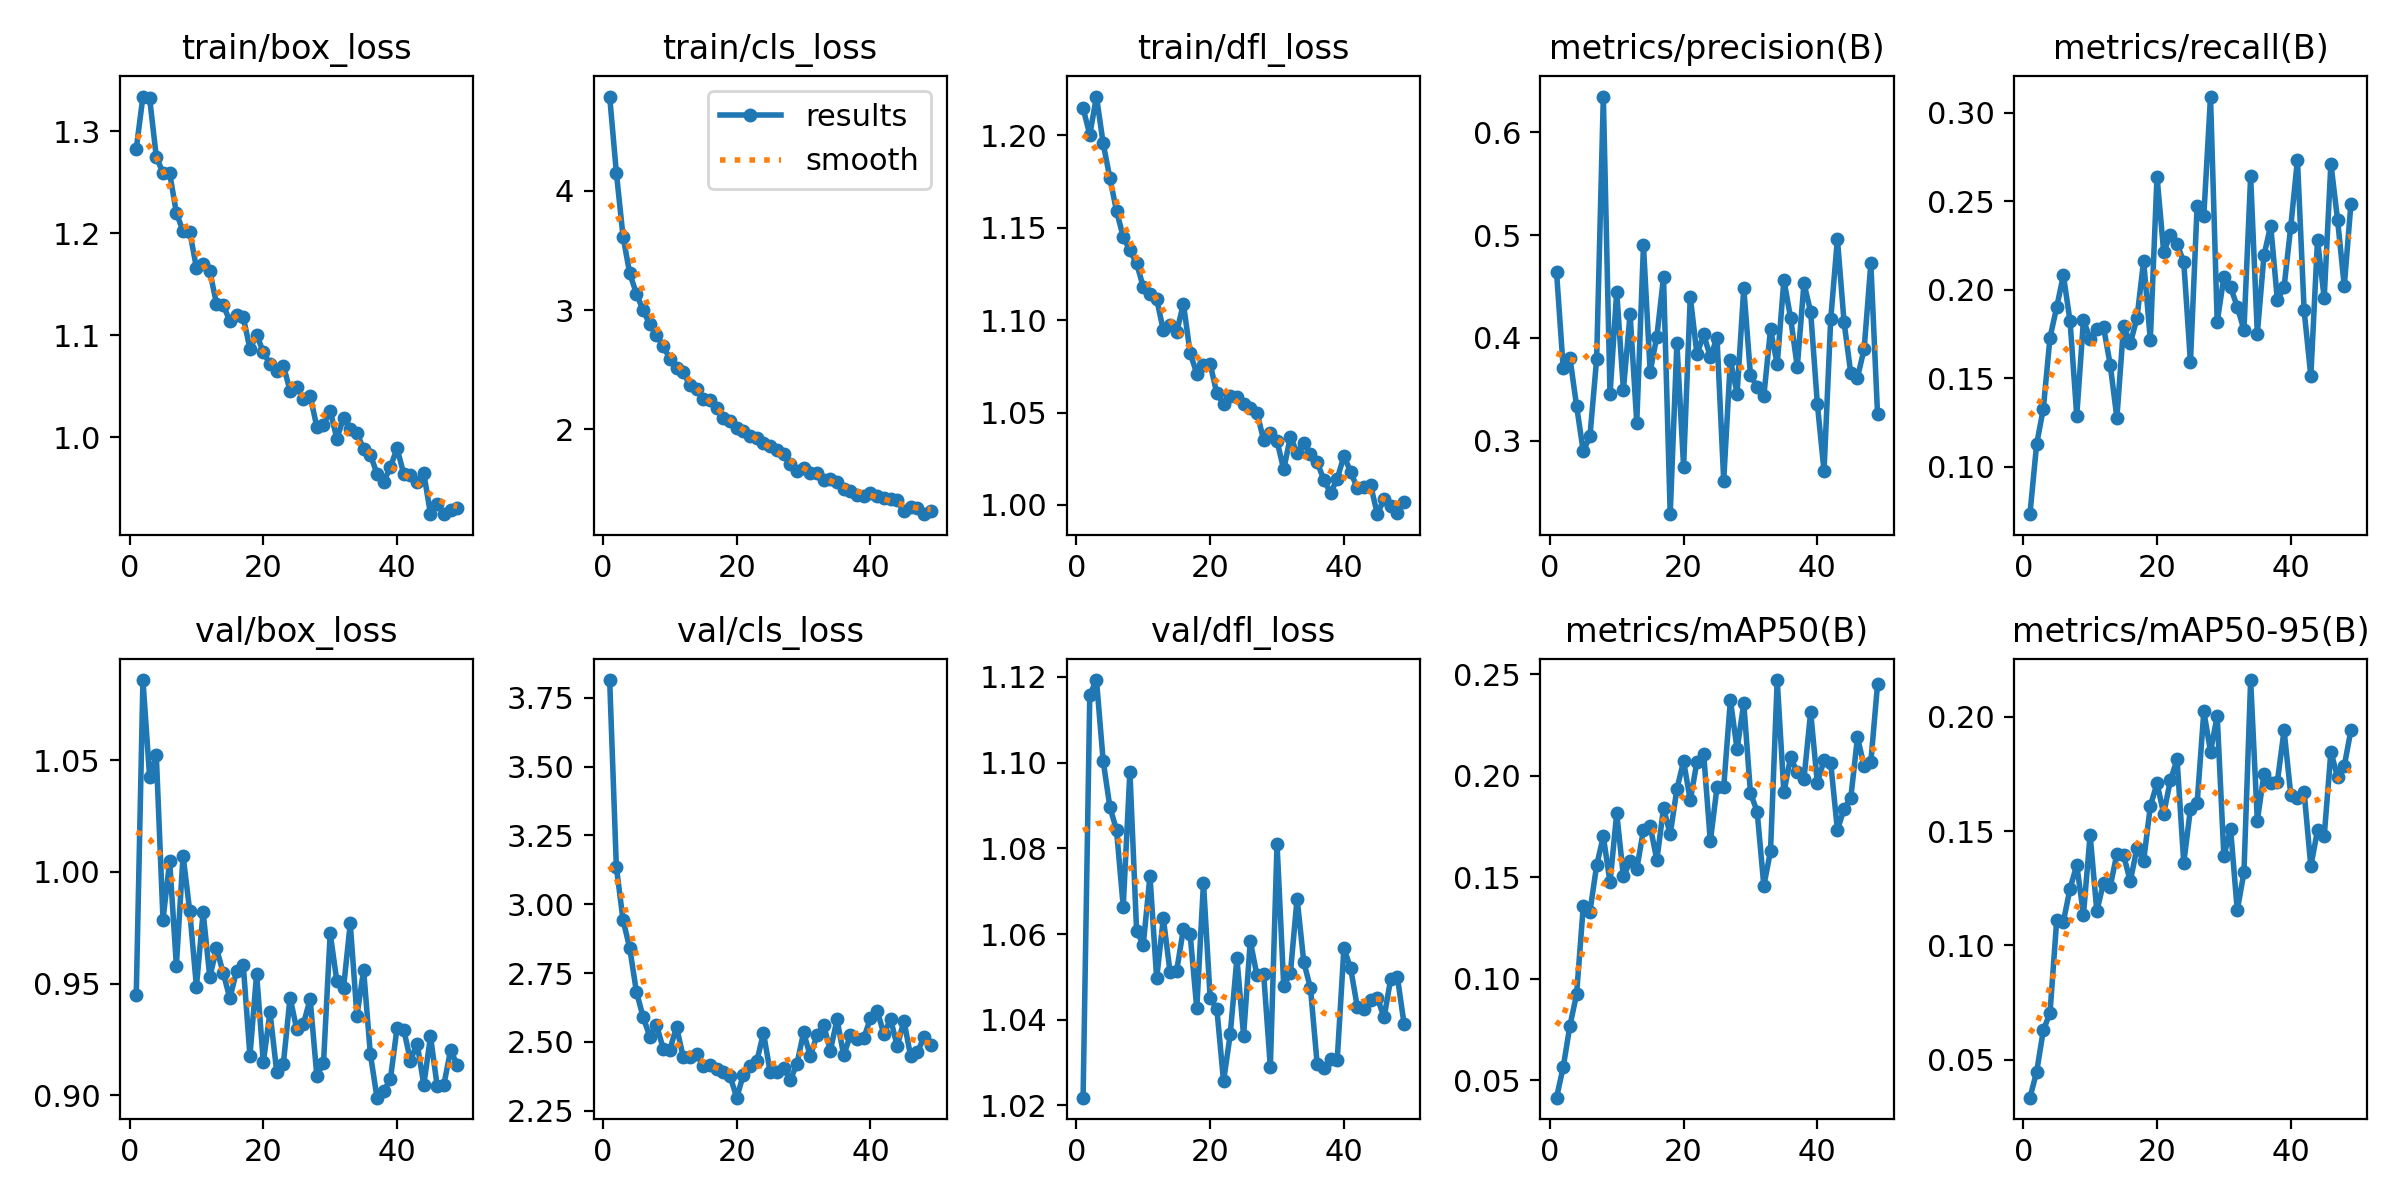

In [1]:
from IPython.display import Image
Image(filename='./runs_yolo/content/runs/detect/train-detec-basura-best/results.png')



# podemos concluir 
Con el análisis de la gráfica anterior podemos indicar, que el modelo aprendió algo (pérdidas de entrenamiento disminuyeron), pero no logró generalizar bien (pérdidas de validación subieron y métricas finales bajas). Es necesario realizar ajustes para mejorar su desempeño.


### **En teoria Curva ideal vs. Actual**

|ideal|actual|
|---|---|
|Pérdidas de entrenamiento y validación convergiendo juntas.|Pérdidas de validación subiendo después de la época 20.|
|mAP50 > 0.5 y mAP50-95 > 0.3.|mAP50 = 0.2 y mAP50-95 = 0.15|

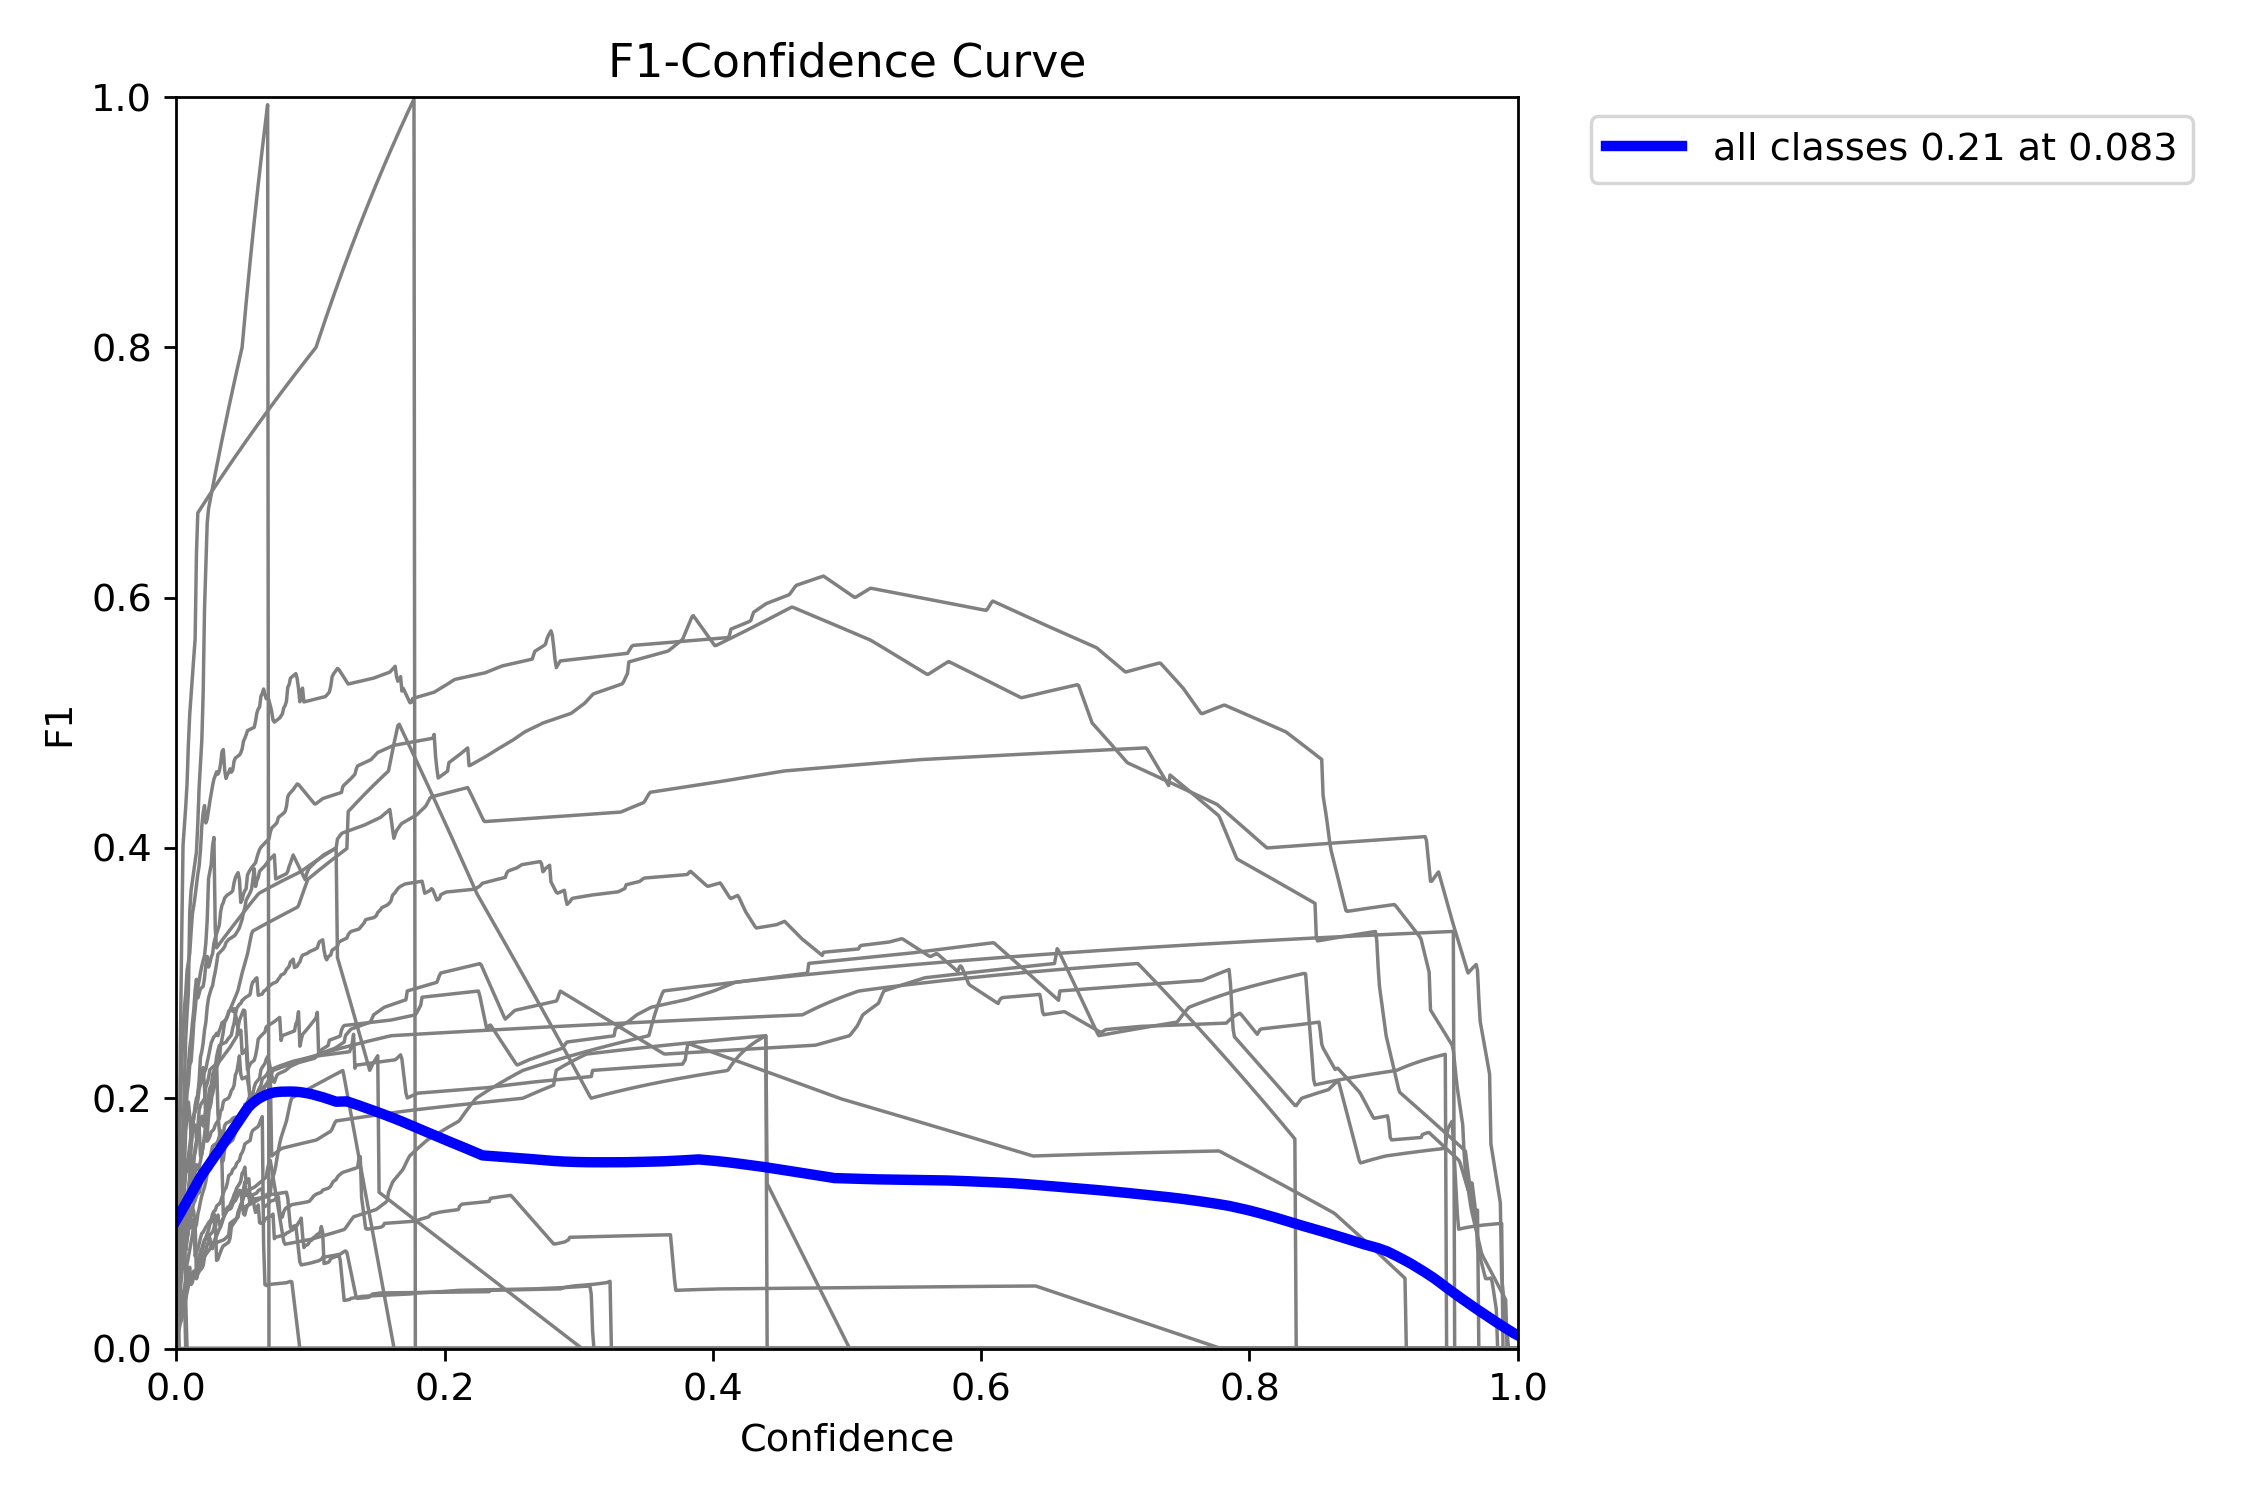

In [2]:
Image(filename='./runs_yolo/content/runs/detect/train-detec-basura-best/BoxF1_curve.png')

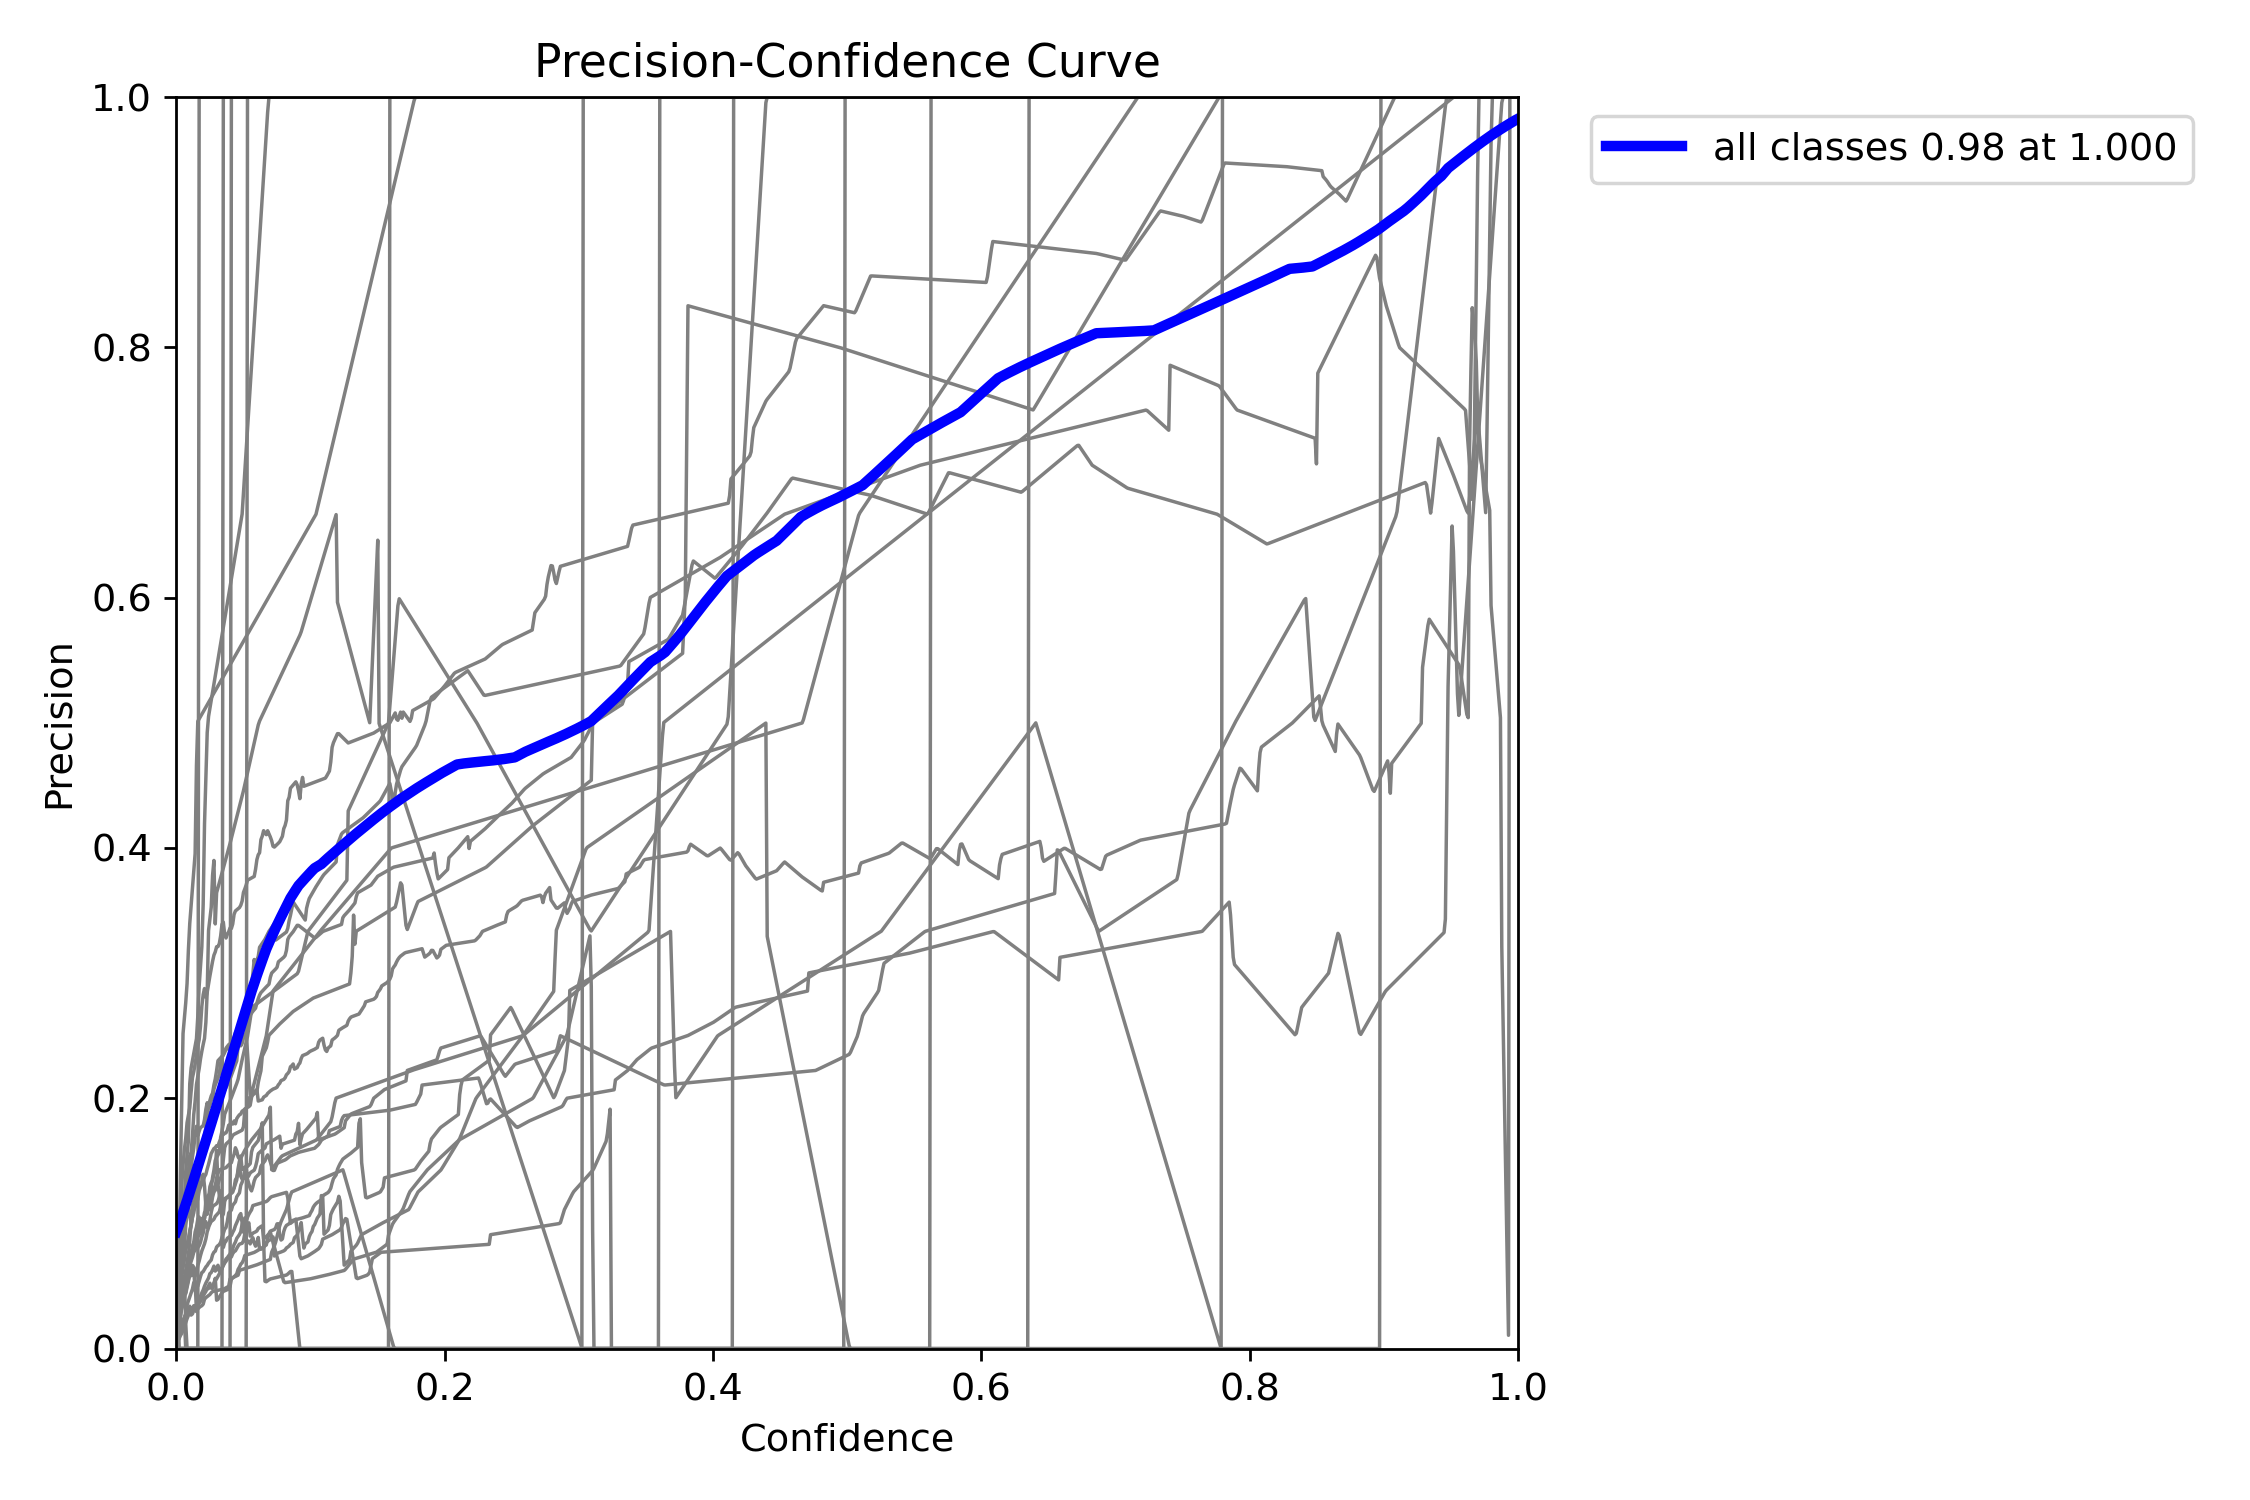

In [3]:
Image(filename='./runs_yolo/content/runs/detect/train-detec-basura-best/BoxP_curve.png')

In [ ]:
## 9. VALIDACIÓN Y PREDICCIÓN

def test_model_predictions(model, test_images_dir, num_samples=5):
    """Probar predicciones del modelo en imágenes de muestra"""

    print(f"\nPROBANDO PREDICCIONES EN {num_samples} IMÁGENES:")

    # Obtener algunas imágenes de validación
    val_images_path = os.path.join(yolo_dataset_path, 'images', 'val')
    if not os.path.exists(val_images_path):
        print("No se encontró directorio de validación")
        return

    image_files = [f for f in os.listdir(val_images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if not image_files:
        print("No se encontraron imágenes en el directorio de validación")
        return

    # Seleccionar imágenes aleatoriamente
    sample_images = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)

    fig, axes = plt.subplots(1, len(sample_images), figsize=(20, 4))
    if len(sample_images) == 1:
        axes = [axes]

    for i, img_file in enumerate(sample_images):
        img_path = os.path.join(val_images_path, img_file)

        # Hacer predicción
        results = model(img_path)

        # Mostrar imagen con predicciones
        annotated_img = results[0].plot()
        axes[i].imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f'Predicción: {img_file}')
        axes[i].axis('off')

        # Mostrar información de detecciones
        detections = results[0].boxes
        if detections is not None and len(detections) > 0:
            print(f"\n{img_file}: {len(detections)} objetos detectados")
            for j, box in enumerate(detections):
                class_id = int(box.cls[0])
                confidence = float(box.conf[0])
                class_name = categories[class_id]['name']
                print(f"  - {class_name}: {confidence:.2f}")
        else:
            print(f"\n{img_file}: No se detectaron objetos")

    plt.tight_layout()
    plt.show()

# Probar predicciones (solo si el modelo fue entrenado exitosamente)
try:
    if 'model' in locals():
        test_model_predictions(model, yolo_dataset_path)
    else:
        print("*Error**  Modelo no disponible para pruebas")
        print("ruta: "+ yolo_dataset_path)
        print("modelo: "+ model)

except Exception as e:
    print(f"*Error*** al probar predicciones: {str(e)}")



### Muestre de resultado en la deteccion de imagnes

Nota: se carga algunas de las imágenes que se generó en la estructura de carpetas de yolo.

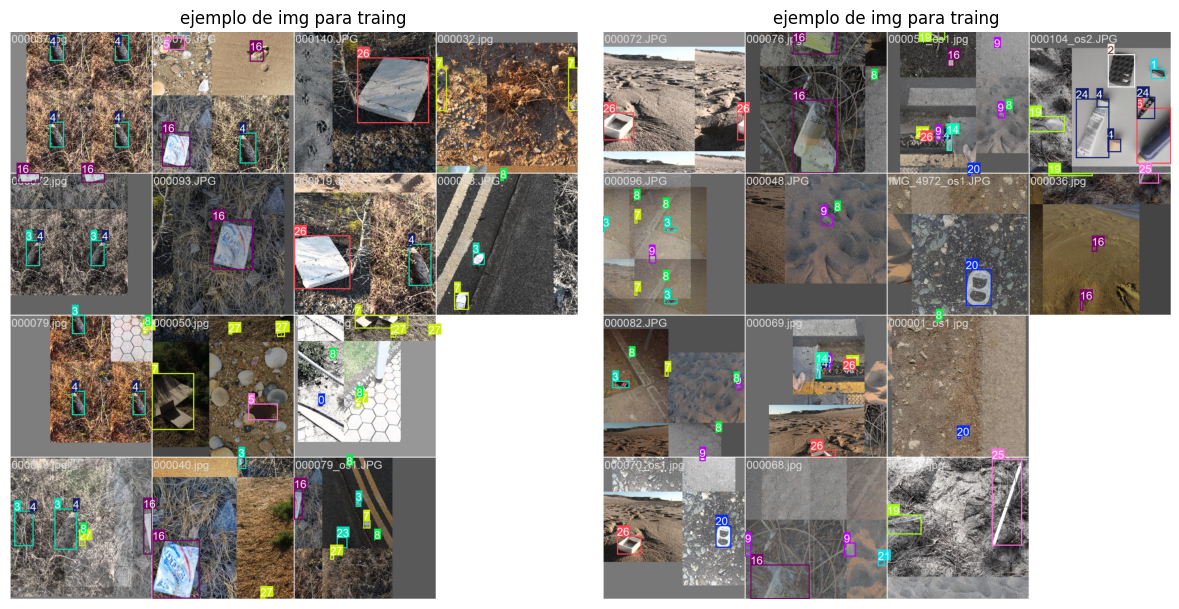

In [ ]:
# Ejemplo img DATA AUGMENTATIONE traing
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


# Cargar las dos imágenes
img1 = np.array(Image.open('./runs_yolo/content/runs/detect/train-detec-basura-best/train_batch0.jpg'))
img2 = np.array(Image.open('./runs_yolo/content/runs/detect/train-detec-basura-best/train_batch1.jpg')) # Cambia esta ruta

# Crear una figura con dos subplots (1 fila, 2 columnas)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Mostrar la primera imagen en el primer subplot
axes[0].imshow(img1)
axes[0].set_title('ejemplo de img para traing')
axes[0].axis('off') # Ocultar los ejes

# Mostrar la segunda imagen en el segundo subplot
axes[1].imshow(img2)
axes[1].set_title('ejemplo de img para traing')
axes[1].axis('off') # Ocultar los ejes

# Ajustar el diseño y mostrar las imágenes
plt.tight_layout()
plt.show()

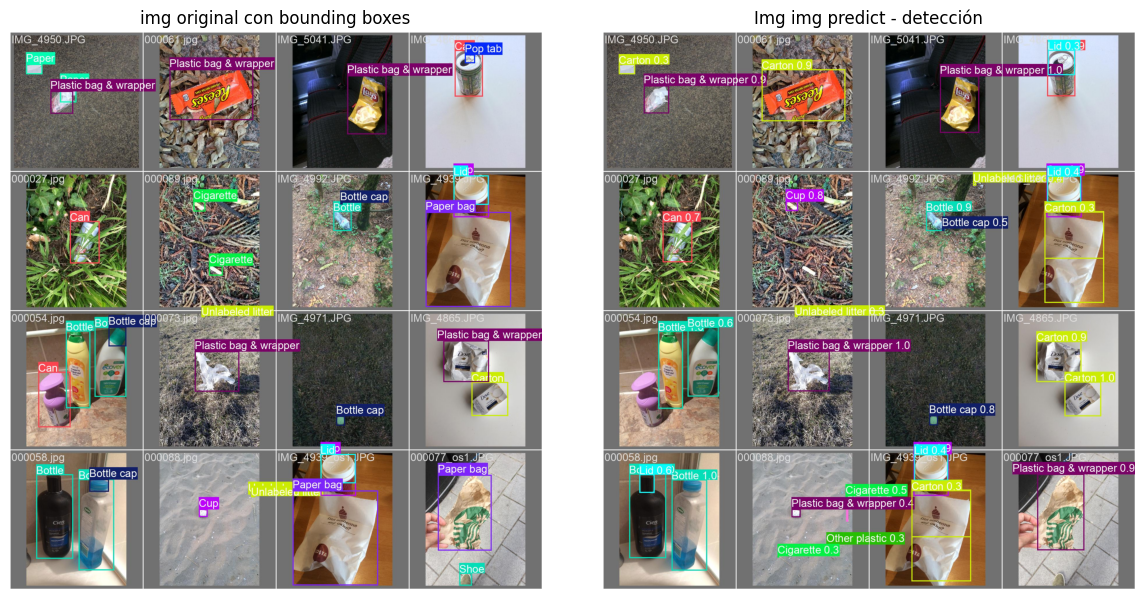

In [10]:
#import matplotlib.pyplot as plt
#import numpy as np
#from PIL import Image

# Cargar las dos imágenes
img1 = np.array(Image.open('./runs_yolo/content/runs/detect/train-detec-basura-best/val_batch2_labels.jpg'))
img2 = np.array(Image.open('./runs_yolo/content/runs/detect/train-detec-basura-best/val_batch2_pred.jpg')) # Cambia esta ruta

# Crear una figura con dos subplots (1 fila, 2 columnas)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Mostrar la primera imagen en el primer subplot
axes[0].imshow(img1)
axes[0].set_title('img original con bounding boxes')
axes[0].axis('off') # Ocultar los ejes

# Mostrar la segunda imagen en el segundo subplot
axes[1].imshow(img2)
axes[1].set_title('Img img predict - detección')
axes[1].axis('off') # Ocultar los ejes

# Ajustar el diseño y mostrar las imágenes
plt.tight_layout()
plt.show()

In [ ]:
#import matplotlib.pyplot as plt
#import numpy as np
#from PIL import Image

# Cargar las dos imágenes
img1 = np.array(Image.open('./runs_yolo/content/runs/detect/train-detec-basura-best/val_batch2_labels.jpg'))
img2 = np.array(Image.open('./runs_yolo/content/runs/detect/train-detec-basura-best/val_batch2_pred.jpg')) # Cambia esta ruta

# Crear una figura con dos subplots (1 fila, 2 columnas)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Mostrar la primera imagen en el primer subplot
axes[0].imshow(img1)
axes[0].set_title('img original con bounding boxes')
axes[0].axis('off') # Ocultar los ejes

# Mostrar la segunda imagen en el segundo subplot
axes[1].imshow(img2)
axes[1].set_title('Img img predict - detección')
axes[1].axis('off') # Ocultar los ejes

# Ajustar el diseño y mostrar las imágenes
plt.tight_layout()
plt.show()

In [33]:
## 10. MÉTRICAS DE EVALUACIÓN FINAL

def evaluate_model(model, yaml_config_path):
    """Evaluar el modelo entrenado"""

    print(f"\nEVALUACIÓN FINAL DEL MODELO:")

    try:
        # Validar modelo
        validation_results = model.val(data=yaml_config_path)

        # Mostrar métricas
        metrics = validation_results.results_dict

        print(f"mAP50: {metrics.get('metrics/mAP50(B)', 'N/A'):.4f}")
        print(f"mAP50-95: {metrics.get('metrics/mAP50-95(B)', 'N/A'):.4f}")
        print(f"Precisión: {metrics.get('metrics/precision(B)', 'N/A'):.4f}")
        print(f"Recall: {metrics.get('metrics/recall(B)', 'N/A'):.4f}")

        return validation_results

    except Exception as e:
        print(f"**Error*** durante la evaluación: {str(e)}")
        return None

# Evaluar modelo final
try:
    if 'model' in locals():
        final_results = evaluate_model(model, yaml_config_path)
    else:
        print("**Error** Modelo no disponible para evaluación")
except Exception as e:
    print(f"**Error** Error en evaluación final: {str(e)}")


EVALUACIÓN FINAL DEL MODELO:
Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,587,612 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3447.1±612.5 MB/s, size: 1062.4 KB)


val: Scanning /content/yolo_taco_dataset/labels/val/batch_1.cache... 164 images, 0 backgrounds, 0 corrupt: 100%|██████████| 164/164 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.31it/s]


                   all        164        453      0.378      0.306      0.249      0.217
        Aluminium foil          2          2       0.11        0.5      0.094     0.0776
                Bottle         41         51      0.444      0.667      0.649      0.538
            Bottle cap         28         34       0.34      0.441       0.38      0.319
                   Can         25         31      0.343      0.677      0.506      0.397
                Carton         17         19      0.152      0.421      0.246      0.224
             Cigarette         20         38     0.0991      0.132     0.0584      0.039
                   Cup         14         15      0.171      0.533       0.32      0.296
            Food waste          2          2          1          0          0          0
             Glass jar          2          2          1          0      0.051      0.051
                   Lid         12         12      0.156      0.167      0.172       0.14
         Other plasti

In [34]:
### 11. GUARDAR INFORMACIÓN DEL EXPERIMENTO -- PARA 60 CATEGORÍAS
#
#def save_experiment_info():
#    """Guardar información del experimento"""
#
#    experiment_info = {
#        'dataset': 'TACO Trash Dataset',
#        'model': f'YOLOv11{MODEL_SIZE}',
#        'epochs': EPOCHS,
#        'image_size': IMG_SIZE,
#        #'batch_size': BATCH_SIZE,
#        'batch_size':AUTO_BATCH_SIZE,
#        'num_classes': len(categories),  # 60 clases
#        'train_images': len(train_images),
#        'val_images': len(val_images),
#        'device': AUTO_DEVICE,          # Agregar información del dispositivo
#        'workers': AUTO_WORKERS,        # Agregar información de workers
#        'mixed_precision': AUTO_AMP,    # Agregar información de mixed precision
#        'seed': seed,                   # Agregar semilla usada
#        'categories': [cat['name'] for cat in categories]
#    }
#
#    experiment_file = os.path.join(yolo_dataset_path, 'experiment_info.json')
#
#    with open(experiment_file, 'w') as f:
#        json.dump(experiment_info, f, indent=2)
#
#    print(f"\nInformación del experimento guardada en: {experiment_file}")
#
#    return experiment_info
#
## Guardar información
#experiment_info = save_experiment_info()
#
#print(f"\n¡ENTRENAMIENTO COMPLETADO!")
#print(f"Dataset: {experiment_info['train_images']} imágenes de entrenamiento, {experiment_info['val_images']} de validación")
#print(f"Modelo: {experiment_info['model']} con {experiment_info['num_classes']} clases")
#print(f"Configuración guardada en: {yolo_dataset_path}")
#print(f"Configuración del experimento: {yolo_dataset_path}/experiment_info.json")
#
#print(f"\n---------------Ver como automatizar si cambia a ruta -------------------")
#print(f"Mejor modelo: runs/detect/train/weights/best.pt")
#print(f"Gráficos de entrenamiento: runs/detect/train/")



In [35]:
## 11. GUARDAR INFORMACIÓN DEL EXPERIMENTO - MODIFICADO PARA SUPERCATEGORÍAS

def save_experiment_info_supercategories():
    """Guardar información del experimento usando SUPERCATEGORÍAS"""

    experiment_info = {
        'dataset': 'TACO Trash Dataset',
        'model': f'YOLOv11{MODEL_SIZE}',
        'experiment_type': 'Supercategories Training',  # Nuevo campo para identificar el tipo
        'epochs': EPOCHS,
        'image_size': IMG_SIZE,
        'batch_size': AUTO_BATCH_SIZE,
        'num_classes': len(unique_supercategories),  # 28 en lugar de 60
        'train_images': len(train_images),
        'val_images': len(val_images),
        'device': AUTO_DEVICE,                       # Agregar información del dispositivo
        'workers': AUTO_WORKERS,                     # Agregar información de workers
        'mixed_precision': AUTO_AMP,                 # Agregar información de mixed precision
        'seed': seed,                                # Agregar semilla usada
        'yaml_config_file': 'data_supercategories.yaml',  # Archivo YAML específico
        # INFORMACIÓN ESPECÍFICA DE SUPERCATEGORÍAS
        'original_categories_count': 60,  # Referencia a las categorías originales
        'supercategories_count': len(unique_supercategories),
        'supercategories': unique_supercategories,  # Lista de 28 supercategorías
        'detection_counts_by_supercategory': detection_counts,  # Conteos del bloque 3
        'total_detections_processed': sum(detection_counts.values()),
        # MAPEO PARA REFERENCIA FUTURA
        'supercategory_mapping': supercategory_mapping,  # Mapeo supercategory -> yolo_index
    }

    experiment_file = os.path.join(yolo_dataset_path, 'experiment_info_supercategories.json')

    with open(experiment_file, 'w') as f:
        json.dump(experiment_info, f, indent=2)


    print(f"\nInformación del experimento guardado:")
    print(f"- Ubicación del archivo Archivo: {experiment_file}")
    print(f"- Tipo de experimento: {experiment_info['experiment_type']}")
    print(f"- Clases: {experiment_info['supercategories_count']} supercategorías (reducido desde {experiment_info['original_categories_count']})")
    print(f"- Total de detecciones: {experiment_info['total_detections_processed']}")
    print(f"- Dataset: {experiment_info['dataset']}")
    print(f"- Modelo: {experiment_info['model']}")
    print(f"- Imágenes entrenamiento: {experiment_info['train_images']}")
    print(f"- Imágenes validación: {experiment_info['val_images']}")
    print(f"- Configuración: {experiment_info['yaml_config_file']}")

    # Mostrar resumen de supercategorías más frecuentes
    print(f"\n SUPERCATEGORÍAS MÁS FRECUENTES:")
    sorted_counts = sorted(detection_counts.items(), key=lambda x: x[1], reverse=True)
    #for i, (supercat, count) in enumerate(sorted_counts[:5]):  # top 5
    for i, (supercat, count) in enumerate(sorted_counts[:]):  # top listado completo
        percentage = (count / experiment_info['total_detections_processed']) * 100
        print(f"{i+1}. {supercat:<25}: {count:>4d} detecciones ({percentage:.1f}%)")




    return experiment_info

# EJECUTAR EL GUARDADO DE INFORMACIÓN MODIFICADO
experiment_info_supercategories = save_experiment_info_supercategories()


# CONFIGURACIÓN LISTA PARA ENTRENAMIENTO
print(f"- config del enrenamietno yaml_config_path apunta a: {yaml_config_path}")


## Mostrar comparación mmmmmmmmmm
#print(f"\nCOMPARACIÓN:")
#print(f"{'ANTES:':<20} 60 categorías individuales")
#print(f"{'AHORA:':<20} {len(unique_supercategories)} supercategorías")
#print(f"{'REDUCCIÓN:':<20} {((60 - len(unique_supercategories))/60)*100:.1f}% menos clases")


Información del experimento guardado:
- Ubicación del archivo Archivo: ./yolo_taco_dataset/experiment_info_supercategories.json
- Tipo de experimento: Supercategories Training
- Clases: 28 supercategorías (reducido desde 60)
- Total de detecciones: 4784
- Dataset: TACO Trash Dataset
- Modelo: YOLOv11n
- Imágenes entrenamiento: 1350
- Imágenes validación: 150
- Configuración: data_supercategories.yaml

 SUPERCATEGORÍAS MÁS FRECUENTES:
1. Plastic bag & wrapper    :  850 detecciones (17.8%)
2. Cigarette                :  667 detecciones (13.9%)
3. Unlabeled litter         :  517 detecciones (10.8%)
4. Bottle                   :  439 detecciones (9.2%)
5. Bottle cap               :  289 detecciones (6.0%)
6. Can                      :  273 detecciones (5.7%)
7. Other plastic            :  273 detecciones (5.7%)
8. Carton                   :  251 detecciones (5.2%)
9. Cup                      :  192 detecciones (4.0%)
10. Straw                    :  161 detecciones (3.4%)
11. Paper        

### Instrucciones para uso futuro --- USAR EL MODELO ENTRENADO ---


```python
from ultralytics import YOLO
model = YOLO('runs/detect/train/weights/best.pt')
#------------------------ runs\detect\train\weights
# tambien puede ser otro nombre por el campo name='train-detec-basura-best.pt
model = YOLO('runs/detect/train/weights/train-detec-basura-best.pt')
#------------------------ runs\detect\train-detec-basura-best\weights
results = model('path/to/image.jpg')
```
### Descarga de carpetas del colab 
ejemplo de code
```
!zip -r /content/yolo_results.zip /content/runs/detect/exp
```

Monta tu Google Drive en Colab ejecutando el siguiente código en una celda
```
from google.colab import drive
drive.mount('/content/drive')

```
Copia la carpeta de resultados
```
!cp -r /content/runs/detect/exp "/content/drive/MyDrive/mis_resultados"
```



In [ ]:
## Descargar y comprimir archivos colab 
#!zip -r modelo_yolo.zip /content/modelo/
#!zip -r runs_yolo.zip /content/runs/
#!zip -r sample_data_yolo.zip /content/sample_data/
#!zip -r sample_data_yolo.zip /content/yolo11n.pt
#!zip -r sample_data_yolo.zip /content/yolo_taco_dataset/


Se han truncado las últimas 5000 líneas del flujo de salida.
  adding: content/yolo_taco_dataset/labels/train/batch_1/000053.txt (deflated 48%)
  adding: content/yolo_taco_dataset/labels/train/batch_1/000014.txt (deflated 51%)
  adding: content/yolo_taco_dataset/labels/train/batch_1/000081.txt (deflated 49%)
  adding: content/yolo_taco_dataset/labels/train/batch_1/000099_os1.txt (deflated 42%)
  adding: content/yolo_taco_dataset/labels/train/batch_1/000128_os1.txt (deflated 62%)
  adding: content/yolo_taco_dataset/labels/train/batch_1/000104_os2.txt (deflated 58%)
  adding: content/yolo_taco_dataset/labels/train/batch_1/000029.txt (deflated 29%)
  adding: content/yolo_taco_dataset/labels/train/batch_1/000106.txt (deflated 57%)
  adding: content/yolo_taco_dataset/labels/train/batch_1/000104.txt (deflated 58%)
  adding: content/yolo_taco_dataset/labels/train/batch_1/000087_os1.txt (deflated 44%)
  adding: content/yolo_taco_dataset/labels/train/batch_1/000083_os1.txt (deflated 45%)
  addi